In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
directory_to_img = os.path.join('..', '..', 'images')

In [6]:
seed = 2022

In [7]:

start = datetime(2014, 1, 1)
end = datetime(2022, 6, 20)


tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

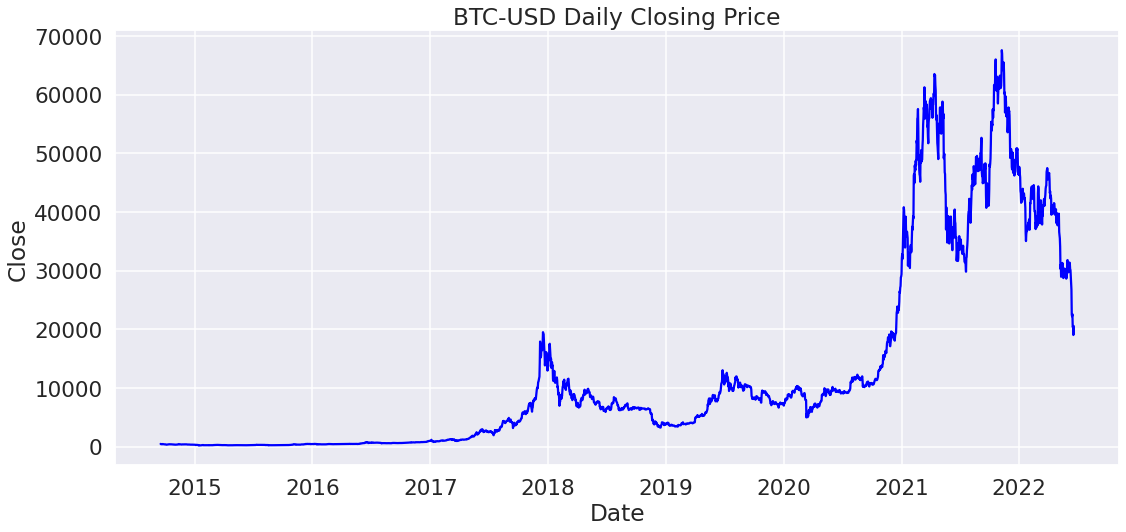

In [8]:

sns.set_context("talk", font_scale=1.3)


with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')    

# plt.tight_layout()
plt.savefig(os.path.join(directory_to_img, 'close.png'), 
            dpi=300, bbox_inches='tight');

In [9]:
df['returns'] = 100 * df.Close.pct_change().dropna()

In [10]:
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [11]:
df.head()

Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits   returns  log_returns  
Date                                                        
2014-09-17          0             0       NaN          NaN  
2014-09-18          0             0 -7.192558    -0.074643  
2014-09-19          0             0 -6.984265    -0.072402  
2014-09-20          0             0  3.573492     0.035111  
2014-09-21          0             0 -2.465854    -0.024968

In [12]:
df.dropna(inplace=True)

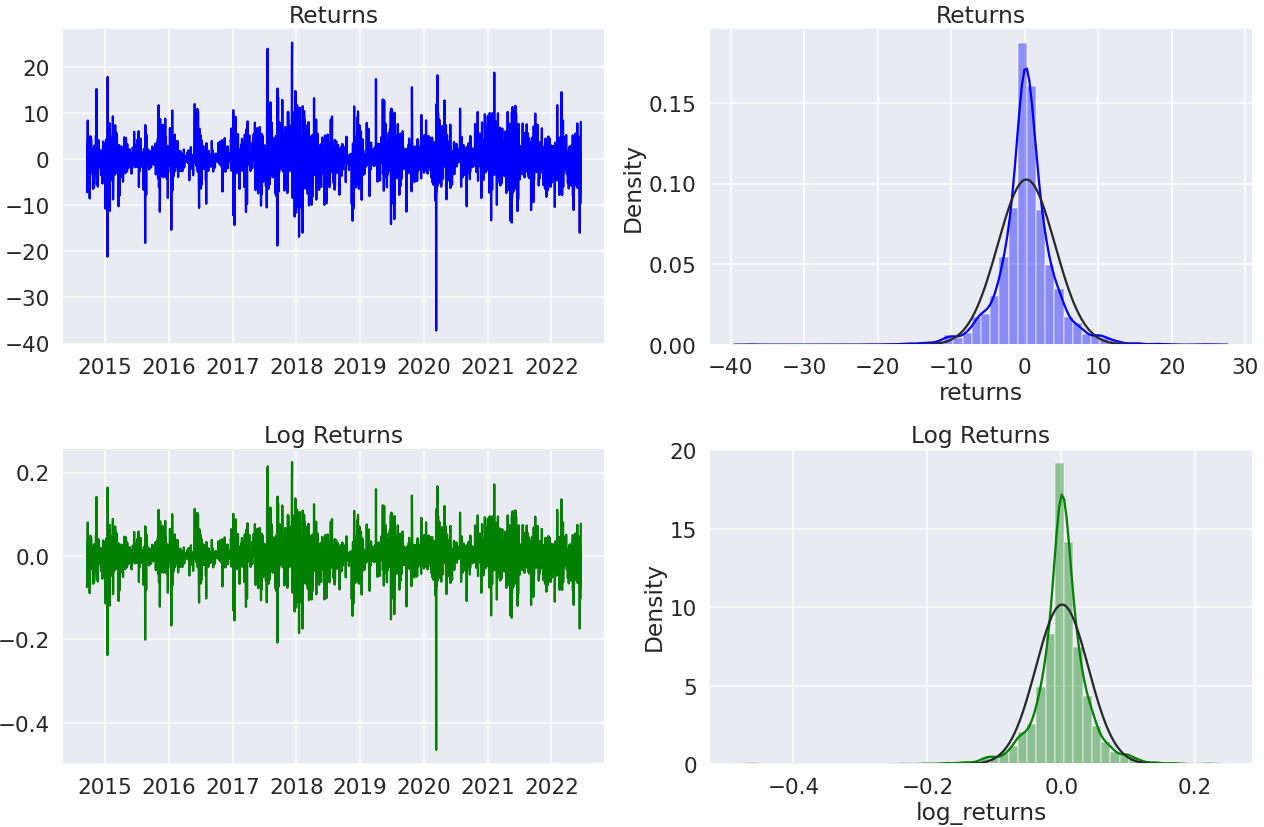

In [13]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'returns_logreturns.png'), 
                dpi=300, bbox_inches='tight')
    fig.show();

In [14]:
df.returns.describe()

count    2832.000000
mean        0.210855
std         3.890023
min       -37.169539
25%        -1.376378
50%         0.196187
75%         1.825204
max        25.247169
Name: returns, dtype: float64

In [15]:
df.log_returns.describe()

count    2832.000000
mean        0.001344
std         0.039236
min        -0.464730
25%        -0.013859
50%         0.001960
75%         0.018087
max         0.225119
Name: log_returns, dtype: float64

In [16]:
def realized_volatility_daily(series_log_return):
   
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [17]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

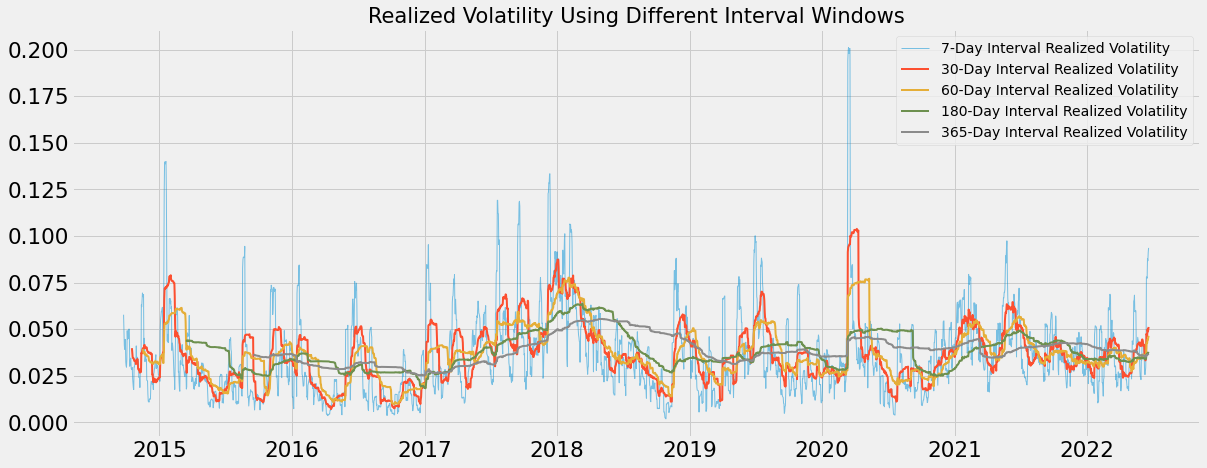

In [18]:

plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
plt.savefig(os.path.join(directory_to_img, 'diff_intervals.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [19]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [20]:
df.describe()

Open          High           Low         Close        Volume  \
count   2832.000000   2832.000000   2832.000000   2832.000000  2.832000e+03   
mean   12389.098026  12711.892942  12026.163435  12394.536244  1.537860e+10   
std    16625.269656  17054.845693  16126.429090  16620.709657  1.996490e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      628.599747    638.863770    619.822250    630.231766  8.588007e+07   
50%     6518.840088   6627.135010   6445.995117   6529.379883  5.663630e+09   
75%    11422.925781  11706.432129  11167.951904  11426.801270  2.621062e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

       Dividends  Stock Splits      returns  log_returns  vol_current  \
count     2832.0        2832.0  2832.000000  2832.000000  2803.000000   
mean         0.0           0.0     0.210855     0.001344     0.036202   
std          0.0           0.0     3.890023     0.039236     0.016425   
min          0.0           0.0   -37.169539    -0.464730     0.007228   
25%          0.0           0.0    -1.376378    -0.013859     0.025249   
50%          0.0           0.0     0.196187     0.001960     0.034194   
75%          0.0           0.0     1.825204     0.018087     0.044779   
max          0.0           0.0    25.247169     0.225119     0.103878   

        vol_future  
count  2796.000000  
mean      0.036204  
std       0.016445  
min       0.007228  
25%       0.025228  
50%       0.034185  
75%       0.044788  
max       0.103878

In [21]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [22]:
df.describe()

Open          High           Low         Close        Volume  \
count   2832.000000   2832.000000   2832.000000   2832.000000  2.832000e+03   
mean   12389.098026  12711.892942  12026.163435  12394.536244  1.537860e+10   
std    16625.269656  17054.845693  16126.429090  16620.709657  1.996490e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      628.599747    638.863770    619.822250    630.231766  8.588007e+07   
50%     6518.840088   6627.135010   6445.995117   6529.379883  5.663630e+09   
75%    11422.925781  11706.432129  11167.951904  11426.801270  2.621062e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  2832.000000  2832.000000  2803.000000  2796.000000  
mean      0.210855     0.001344     0.036202     0.036204  
std       3.890023     0.039236     0.016425     0.016445  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.376378    -0.013859     0.025249     0.025228  
50%       0.196187     0.001960     0.034194     0.034185  
75%       1.825204     0.018087     0.044779     0.044788  
max      25.247169     0.225119     0.103878     0.103878

In [23]:
df.dropna(inplace=True)

### **Daily Volatility Grouped by Month**

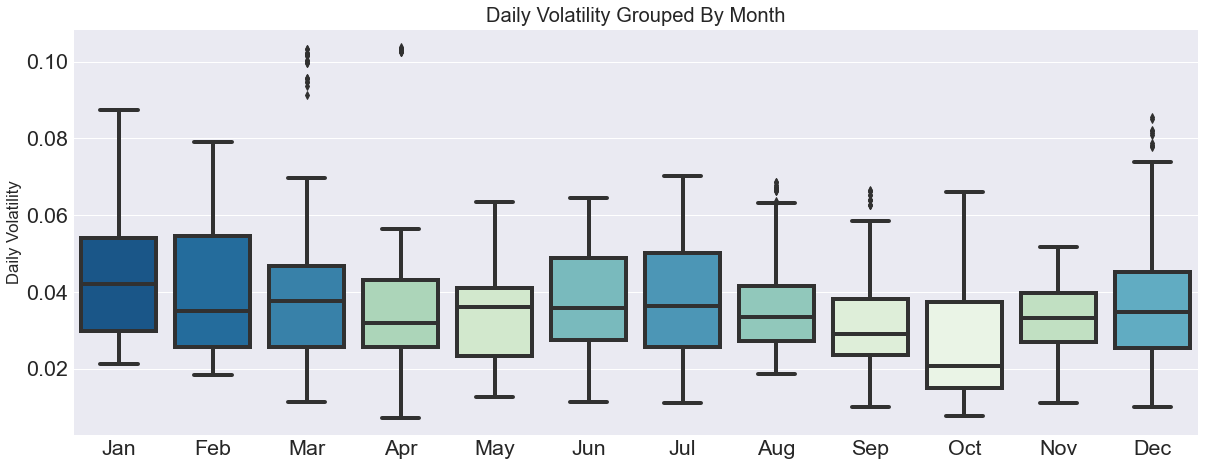

In [24]:

ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = df.groupby(by=[df.index.month_name()]).vol_current.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in df.index.month_name()], 
                y=df.vol_current, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')
    plt.savefig(os.path.join(directory_to_img, "vol_by_month.png"), 
                dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06    0.103878
2020-04-03    0.103330
2020-04-02    0.103319
2020-03-30    0.103302
2020-03-31    0.103300
2020-04-01    0.103203
2020-04-05    0.103192
2020-04-04    0.103175
2020-04-10    0.103052
2020-04-07    0.102421
2020-04-09    0.102414
2020-04-08    0.102411
2020-03-29    0.102179
2020-03-24    0.102140
2020-03-25    0.102018
2020-03-23    0.101864
2020-03-26    0.101844
2020-03-28    0.101738
2020-03-27    0.101523
2020-03-22    0.100300
2020-03-19    0.100166
2020-03-20    0.099710
2020-03-21    0.099709
2020-03-17    0.095724
2020-03-18    0.095614
2020-03-16    0.095421
2020-03-15    0.094782
2020-03-14    0.094559
2020-03-13    0.093746
2020-03-12    0.091405
2018-01-02    0.087396
2018-01-04    0.087307
2018-01-03    0.087271
2018-01-01    0.085787
2017-12-31    0.085544
2017-12-30    0.084937
2018-01-05    0.083116
2017-12-28    0.082083
2017-12-29    0.082024
2017-12-26    0.081314
2017-12-27    0.080819
2015-02-01    0.078996
2018-02-14    0.078846
2017-1

### **Daily Volatility Grouped by Year**

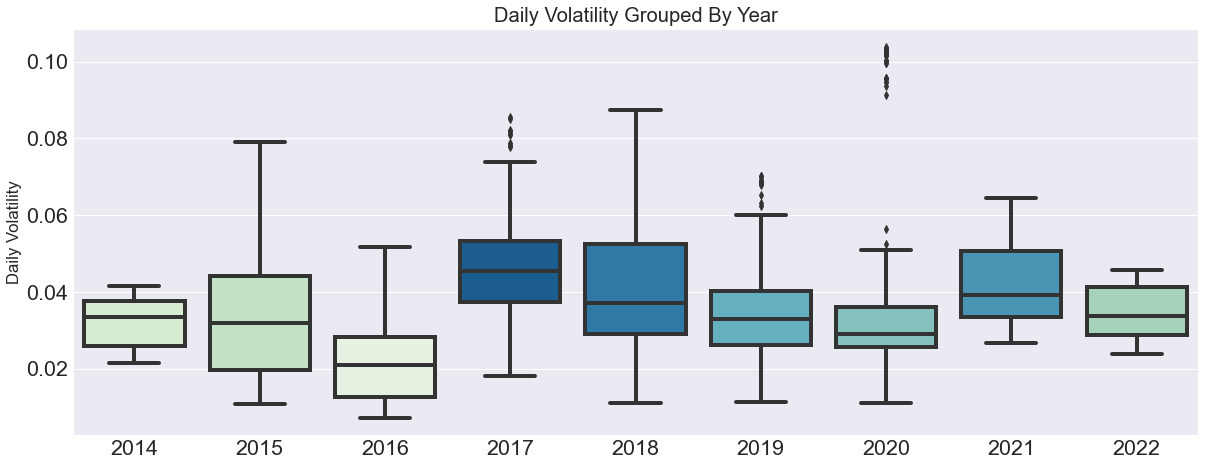

In [26]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=df.index.year, 
                y=df.vol_current, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')
    plt.savefig(os.path.join(directory_to_img, "vol_by_year.png"), 
                dpi=300, bbox_inches='tight')
    plt.show()

## **Train-Validation-Test Splits**



In [27]:

test_size = 30
val_size = 365


split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [28]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-10-17 00:00:00 	to: 2021-05-13 00:00:00 	2401 days
VALIDATION 	From: 2021-05-14 00:00:00 	to: 2022-05-13 00:00:00 	365 days
TEST 		From: 2022-05-14 00:00:00 	to: 2022-06-12 00:00:00 	30 days


In [29]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [30]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [31]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [32]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [33]:
y_train.describe()

count    2401.000000
mean        0.035921
std         0.017331
min         0.007228
25%         0.024086
50%         0.033259
75%         0.045627
max         0.103878
Name: vol_future, dtype: float64

In [34]:
x_train.describe()

count    2401.000000
mean        0.035879
std         0.017313
min         0.007228
25%         0.024086
50%         0.033259
75%         0.045496
max         0.103878
Name: vol_current, dtype: float64

## **Data Preprocessing**




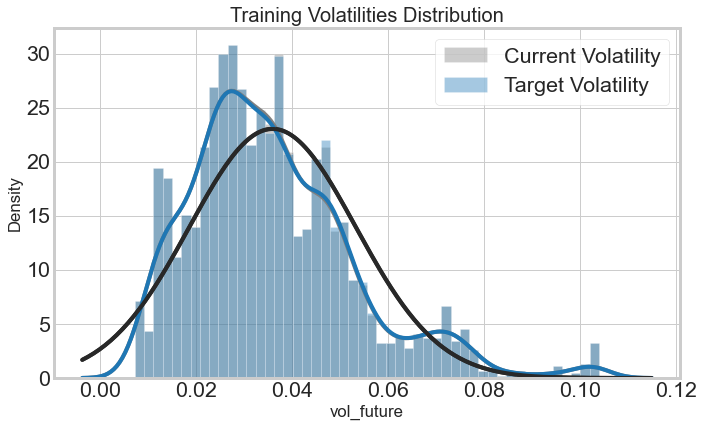

In [35]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.savefig(os.path.join(directory_to_img, "vol_dist.png"), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [36]:
def transform_volatility_to_scaler(scaler, tf_series):
   
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [37]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [38]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [39]:
x_train.head(10)

Date
2014-10-17    0.039872
2014-10-18    0.037566
2014-10-19    0.035089
2014-10-20    0.034629
2014-10-21    0.034362
2014-10-22    0.034364
2014-10-23    0.033347
2014-10-24    0.032900
2014-10-25    0.033009
2014-10-26    0.033083
Name: vol_current, dtype: float64

In [40]:
y_train.head(10)

Date
2014-10-17    0.032900
2014-10-18    0.033009
2014-10-19    0.033083
2014-10-20    0.033017
2014-10-21    0.031334
2014-10-22    0.033474
2014-10-23    0.033426
2014-10-24    0.033602
2014-10-25    0.034075
2014-10-26    0.033154
Name: vol_future, dtype: float64

In [41]:
x_train_scaled.head(10)

Date
2014-10-17    0.337754
2014-10-18    0.313894
2014-10-19    0.288269
2014-10-20    0.283501
2014-10-21    0.280738
2014-10-22    0.280764
2014-10-23    0.270238
2014-10-24    0.265613
2014-10-25    0.266743
2014-10-26    0.267507
dtype: float64

In [42]:
y_train_scaled.head(10)

Date
2014-10-17    0.265613
2014-10-18    0.266743
2014-10-19    0.267507
2014-10-20    0.266830
2014-10-21    0.249415
2014-10-22    0.271550
2014-10-23    0.271058
2014-10-24    0.272883
2014-10-25    0.277768
2014-10-26    0.268242
dtype: float64

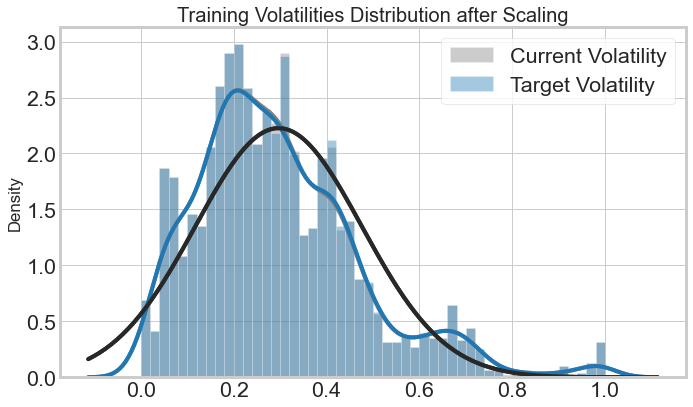

In [43]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.savefig(os.path.join(directory_to_img, "vol_dist.png"), 
                dpi=300, bbox_inches='tight')
    plt.show();

### Train-Validation-Test Visualization

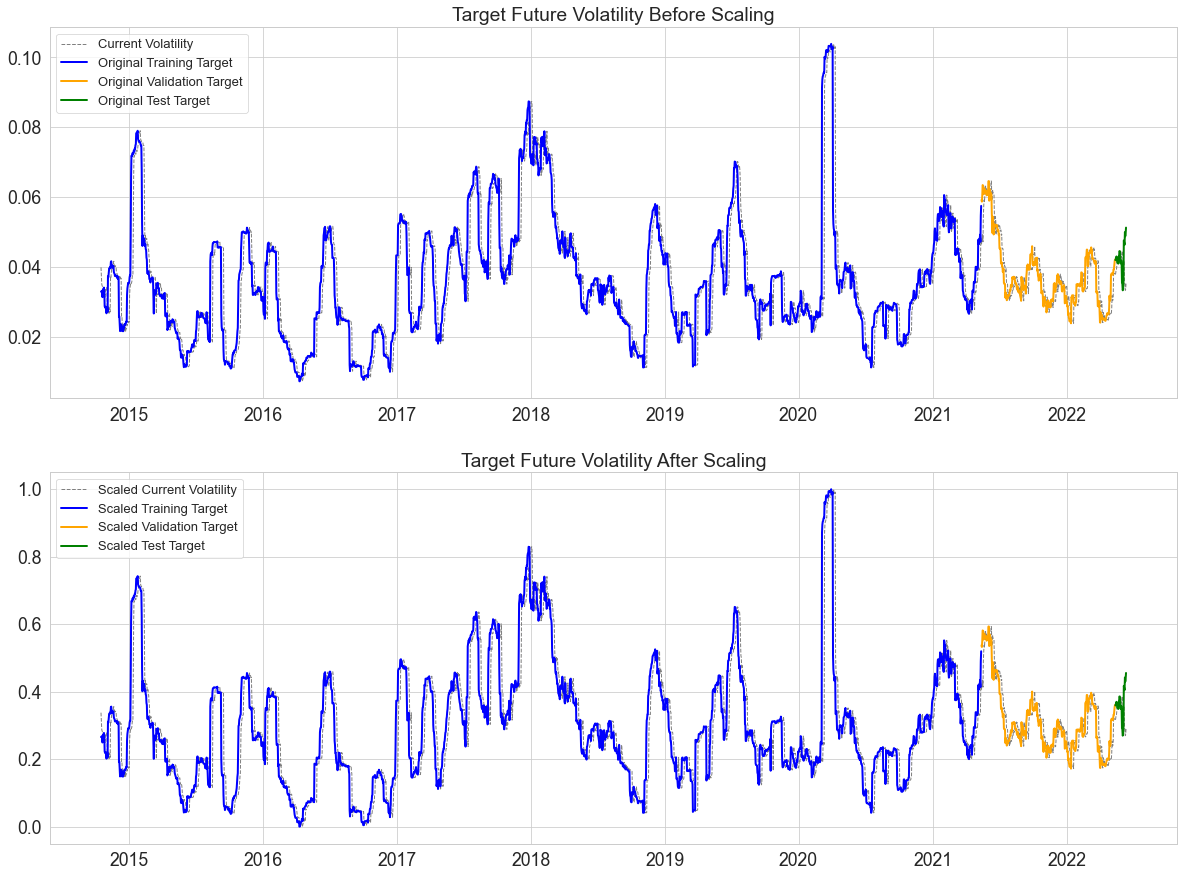

In [44]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.savefig(os.path.join(directory_to_img, 'train_val_test_org_scled.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

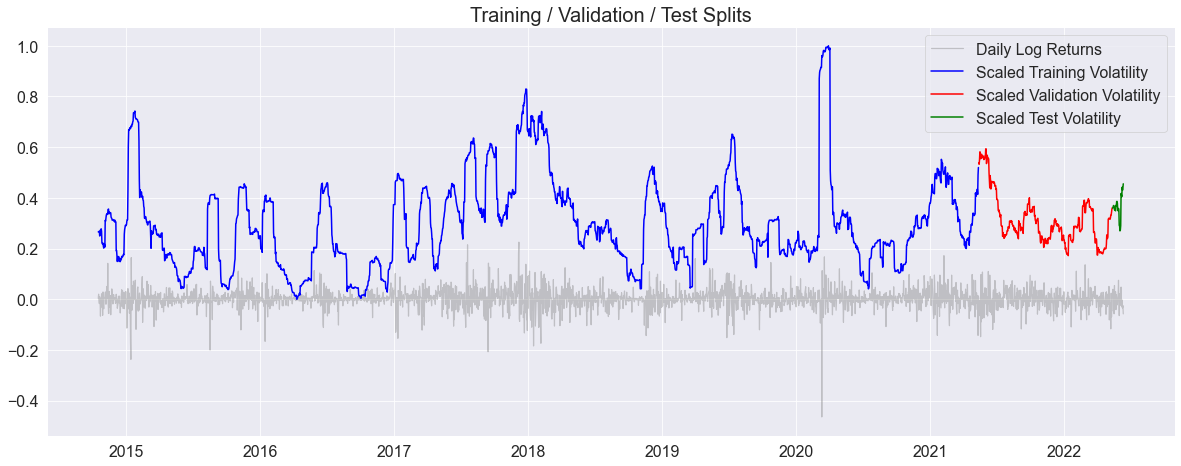

In [45]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)
    plt.savefig(os.path.join(directory_to_img, 'train_val_test.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

# MODELING




In [46]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [47]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [48]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [49]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [50]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)



### Mean Baseline



In [51]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2964366586466327

In [52]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

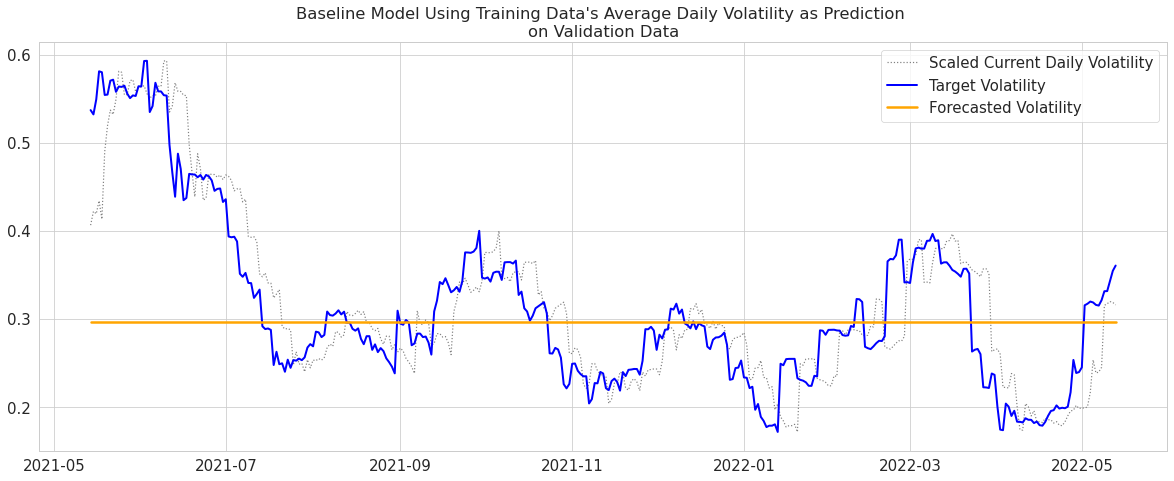

In [53]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.savefig(os.path.join(directory_to_img, 'baseline.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [54]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          0.281034         0.098931

### Random Walk Naive Forecasting


In [55]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

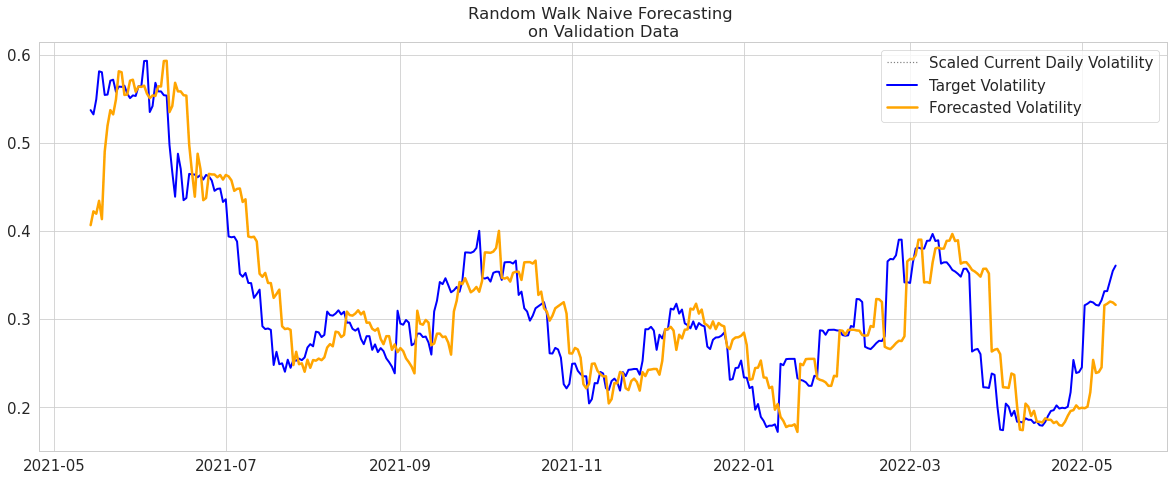

In [56]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.savefig(os.path.join(directory_to_img, 'naive.jpg'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [57]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline          0.281034         0.098931
1  Random Walk Naive Forecasting          0.155975         0.046597

## GARCH Models



### Basic GARCH

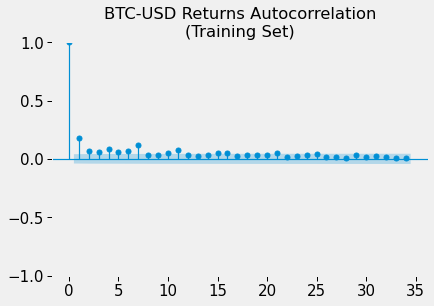

In [58]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

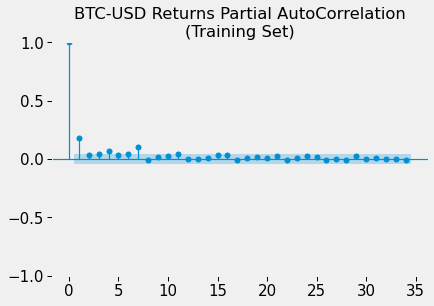

In [59]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [60]:
from arch import arch_model

In [61]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6421.15
Distribution:                  Normal   AIC:                           12874.3
Method:            Maximum Likelihood   BIC:                           12966.8
                                        No. Observations:                 2401
Date:                Mon, Jun 20 2022   Df Residuals:                     2400
Time:                        19:46:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2276  7.050e-02      3.228  1.247e-03 [8.939e-

In [62]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6439.02
Distribution:                  Normal   AIC:                           12886.0
Method:            Maximum Likelihood   BIC:                           12909.2
                                        No. Observations:                 2401
Date:                Mon, Jun 20 2022   Df Residuals:                     2400
Time:                        19:46:47   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2393  6.349e-02      3.769  1.636e-04 [  0.115,  0.3

In [63]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [64]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [65]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

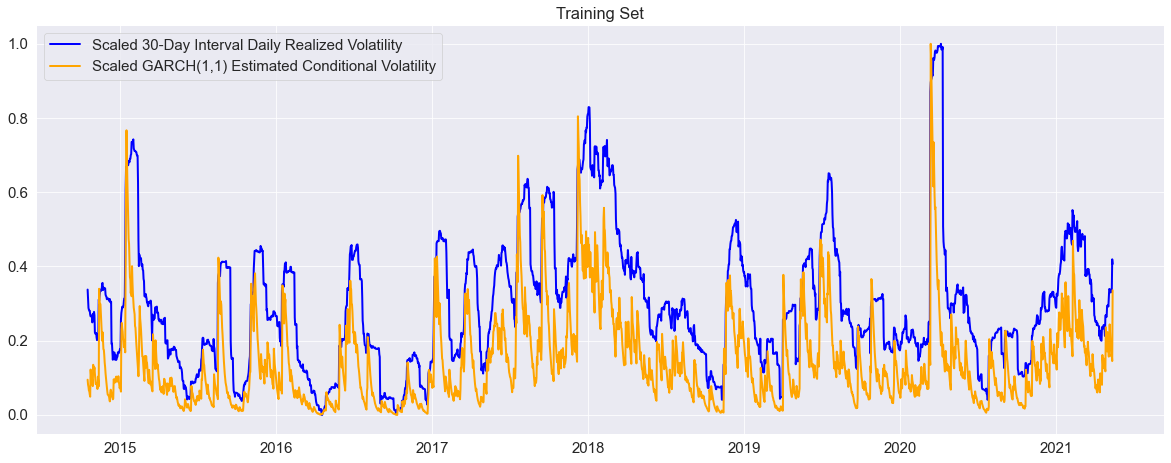

In [66]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

#### Analytical-based Forecasting



In [68]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [69]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

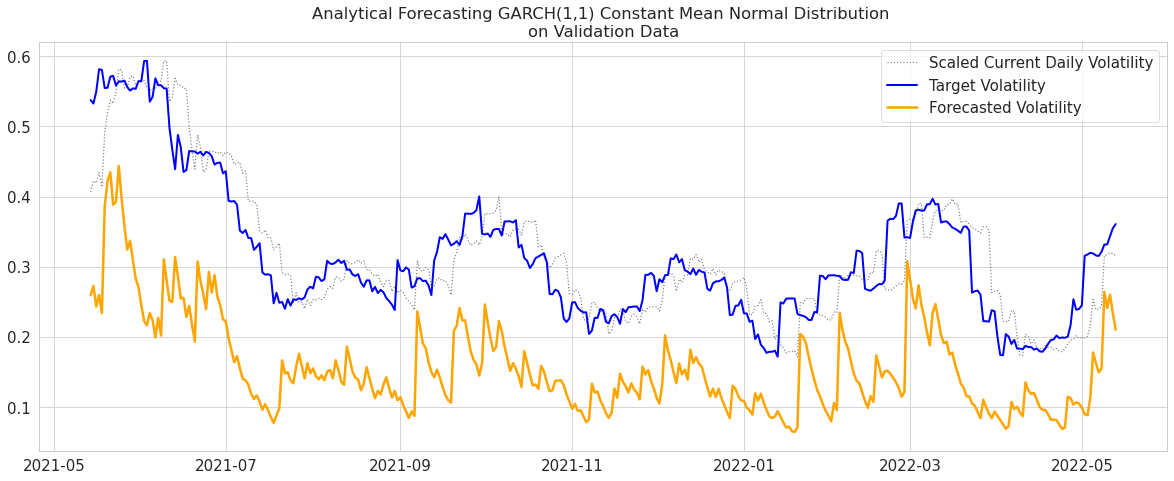

In [70]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

So 7-day horizon forecasting into the future is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalization).

In [71]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          0.281034         0.098931
1           Random Walk Naive Forecasting          0.155975         0.046597
2  GARCH(1,1), Constant Mean, Normal Dist          0.517039         0.167036

Next, I would inspect the estimated residuals from this first GARCH model.

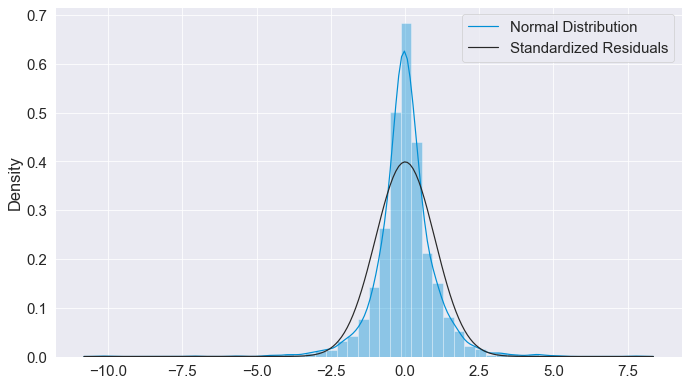

In [72]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

###  GARCH Model with Asymmetric Shocks Responses



In [73]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -6076.14
Distribution:      Standardized Skew Student's t   AIC:                           12166.3
Method:                       Maximum Likelihood   BIC:                           12206.8
                                                   No. Observations:                 2401
Date:                           Mon, Jun 20 2022   Df Residuals:                     2400
Time:                                   19:50:09   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-likelihood has increased quite a bit. Let's see how the conditional volatility looks.

In [74]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

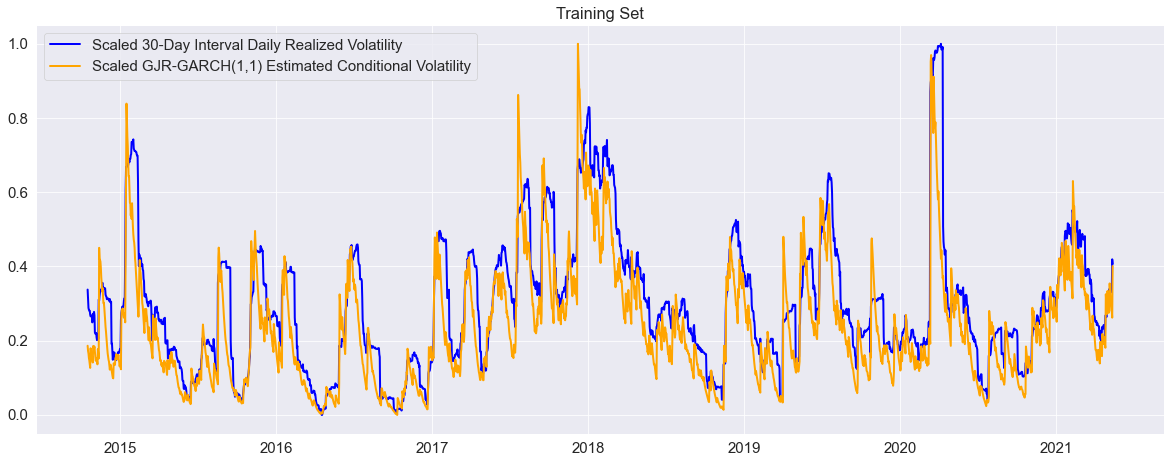

In [75]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [76]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [77]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

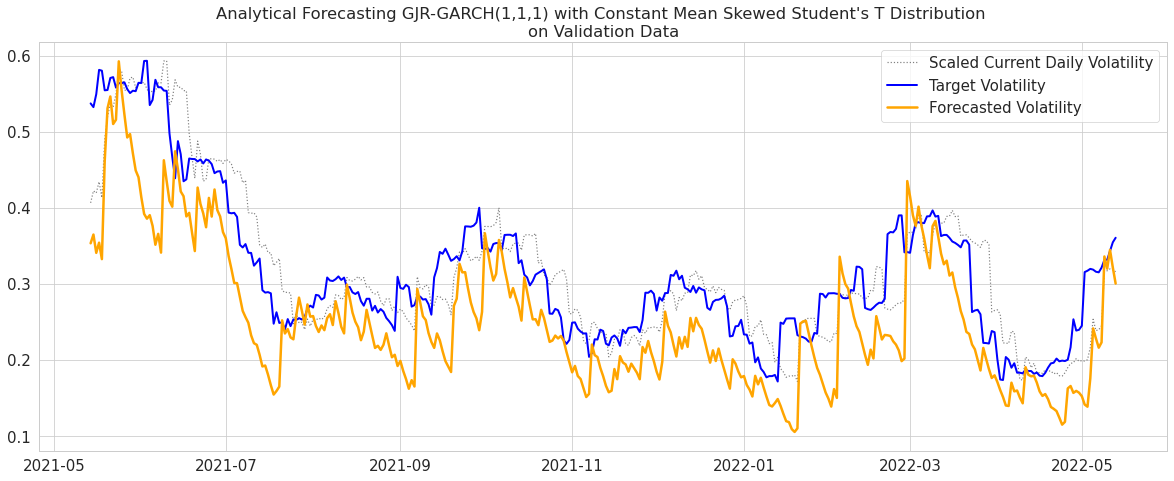

In [78]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [79]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.281034   
1                           Random Walk Naive Forecasting          0.155975   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517039   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.243379   

   Validation RMSE  
0         0.098931  
1         0.046597  
2         0.167036  
3         0.079753

###  TARCH



In [80]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -6074.58
Distribution:      Standardized Skew Student's t   AIC:                           12163.2
Method:                       Maximum Likelihood   BIC:                           12203.6
                                                   No. Observations:                 2401
Date:                           Mon, Jun 20 2022   Df Residuals:                     2400
Time:                                   19:55:30   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [81]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

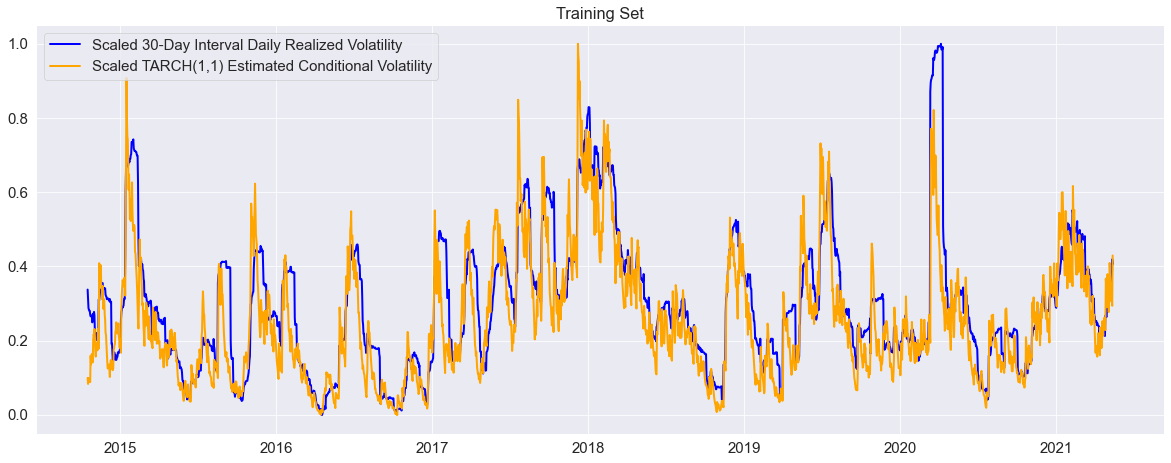

In [82]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

#### Bootstrap-based Forecasting for TARCH(1,1)



In [83]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

In [84]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

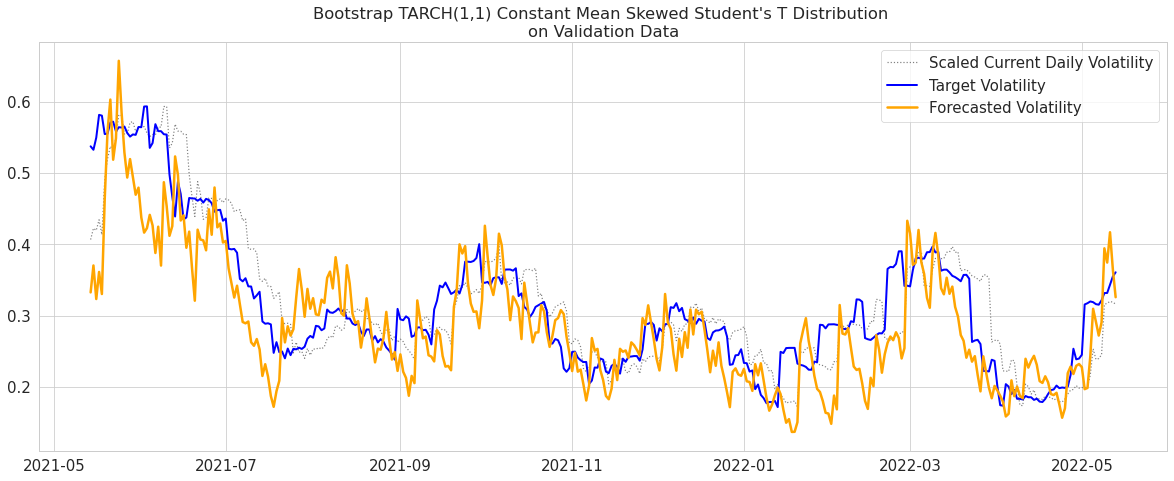

In [85]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [86]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.281034   
1                           Random Walk Naive Forecasting          0.155975   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517039   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.243379   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.185141   

   Validation RMSE  
0         0.098931  
1         0.046597  
2         0.167036  
3         0.079753  
4         0.063112

#### Simulation-based Forecasting for TARCH(1,1)



In [87]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

In [88]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

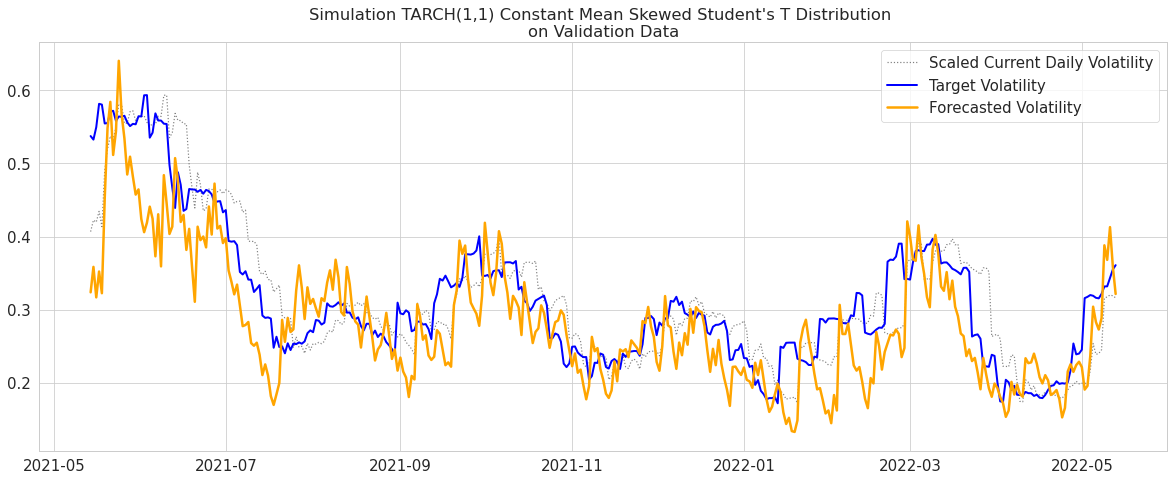

In [89]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [90]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.281034   
1                           Random Walk Naive Forecasting          0.155975   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517039   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.243379   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.185141   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.190546   

   Validation RMSE  
0         0.098931  
1         0.046597  
2         0.167036  
3         0.079753  
4         0.063112  
5         0.065726

####  Hyperparameter Tuning for TARCH



In [91]:
import itertools

In [92]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

In [93]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.17751000803373446 using TARCH(1, 2, 0)


In [94]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

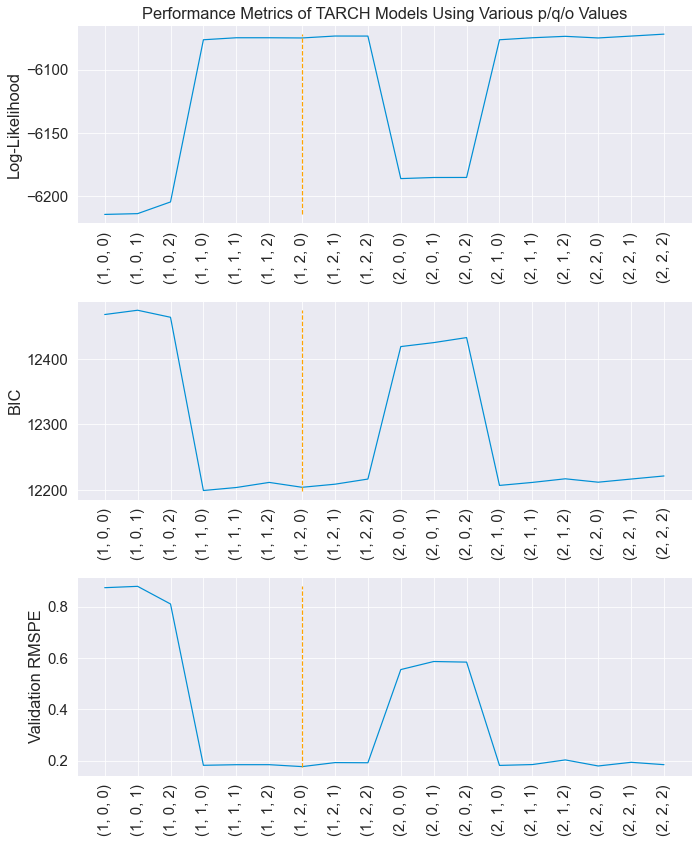

In [95]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();    



### Final GARCH Model - TARCH(1,2)



In [96]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

                          Constant Mean - AVGARCH Model Results                          
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                               AVGARCH   Log-Likelihood:               -6074.74
Distribution:      Standardized Skew Student's t   AIC:                           12163.5
Method:                       Maximum Likelihood   BIC:                           12204.0
                                                   No. Observations:                 2401
Date:                           Mon, Jun 20 2022   Df Residuals:                     2400
Time:                                   21:27:51   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

In [97]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

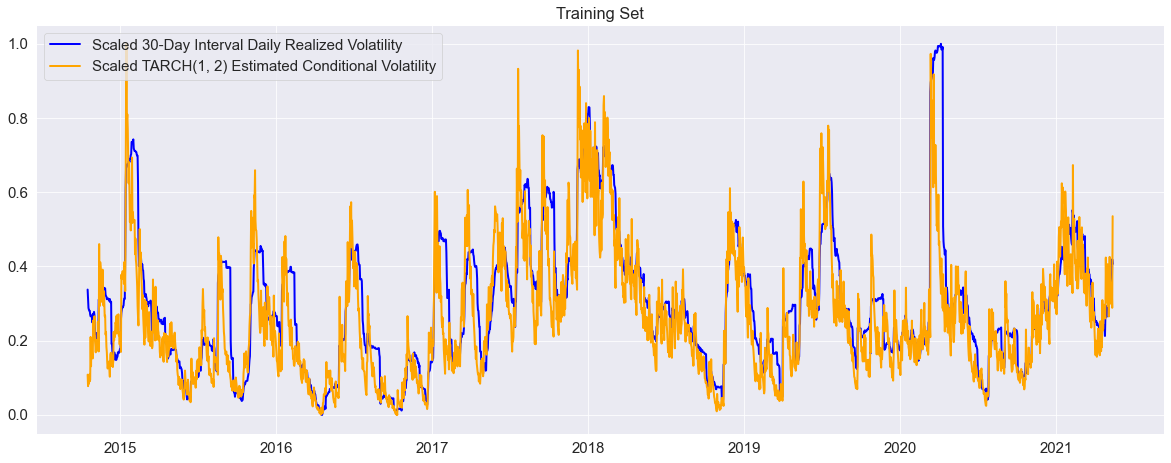

In [98]:
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')

In [99]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\umaimasadaf\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimize

In [100]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

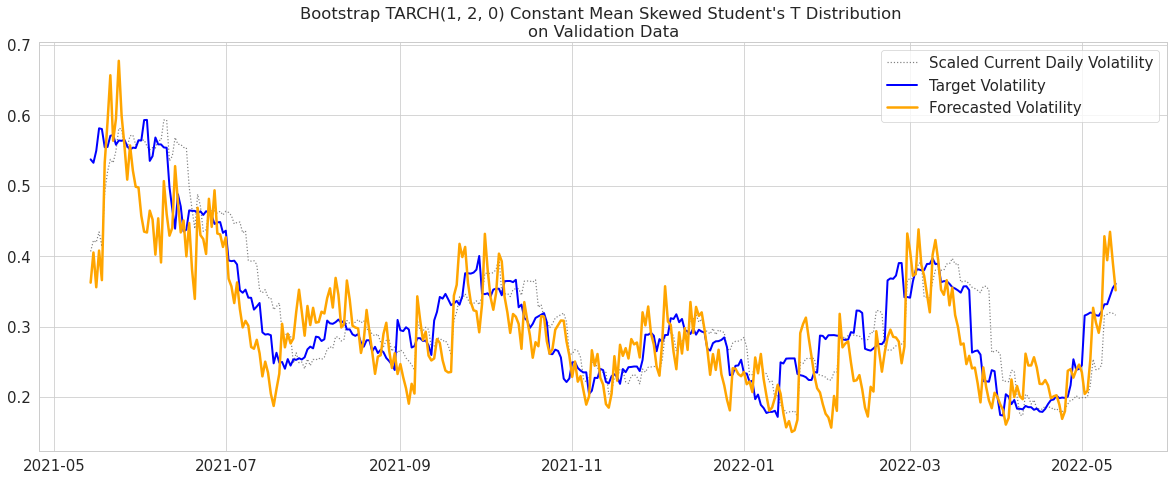

In [101]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled, 
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")
plt.savefig(os.path.join(directory_to_img, 'best_tarch_preds.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [102]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.281034   
1                           Random Walk Naive Forecasting          0.155975   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517039   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.243379   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.185141   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.190546   
6     Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist          0.177546   

   Validation RMSE  
0         0.098931  
1         0.046597  
2         0.167036  
3         0.079753  
4         0.063112  
5         0.065726  
6         0.057666

## 4. Neural Networks



In [103]:
!pip install tensorflow

In [104]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [105]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [106]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [107]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [108]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [109]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

###  Neural Network Baseline Metrics - Fully Connected Network



In [110]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


In [111]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

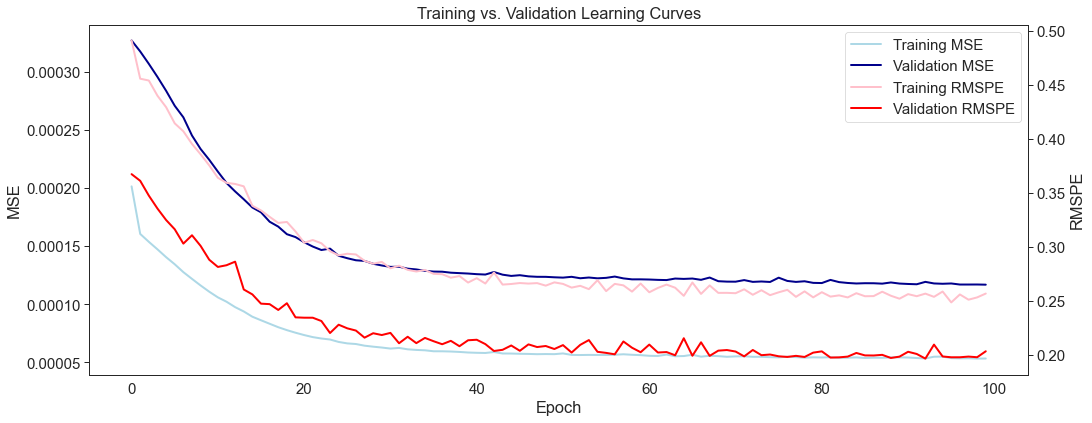

In [112]:
viz_train_val_metrics(snn_1_res)

In [113]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 5ms/step


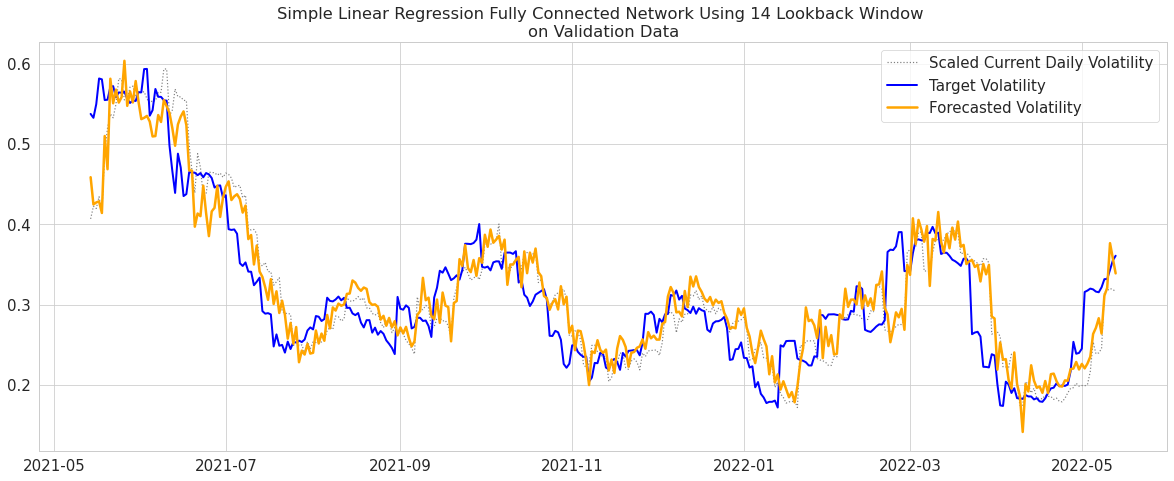

In [114]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
plt.savefig(os.path.join(directory_to_img, 'fully_connected_NN.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

The forecast is tracing the current volatility line very closely, but is mostly lagging behind compared to my target values.

In [115]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.281034   
1                           Random Walk Naive Forecasting          0.155975   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517039   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.243379   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.185141   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.190546   
6     Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist          0.177546   
7                 Simple LR Fully Connected NN, n_past=14          0.146846   

   Validation RMSE  
0         0.098931  
1         0.046597  
2         0.167036  
3         0.079753  
4         0.063112  
5         0.065726  
6         0.057666  
7         0.042970

###  Univariate Long Short-Term Memory (LSTM)



In [116]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


In [117]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

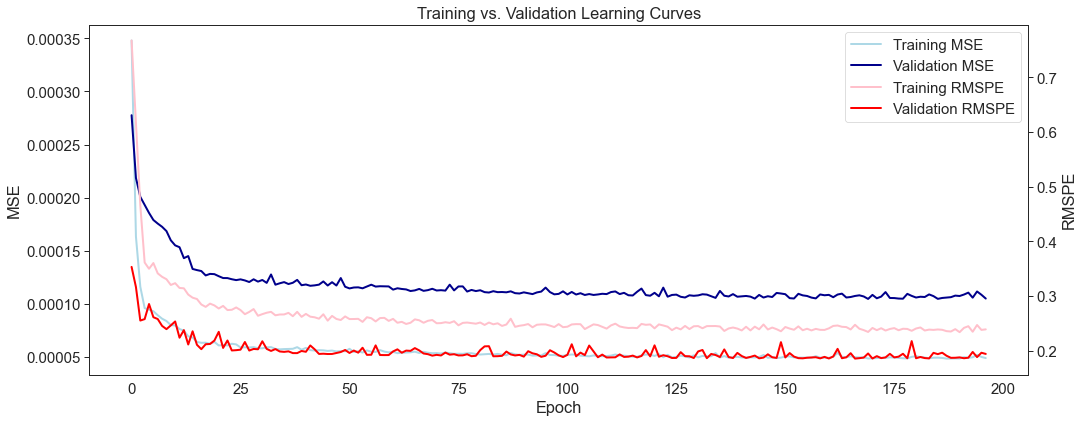

In [118]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

Validation RMSPE is actually lower than Training RMSPE, but overall all the lines except for Training MSE look quite unstable.

In [119]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 2s 9ms/step


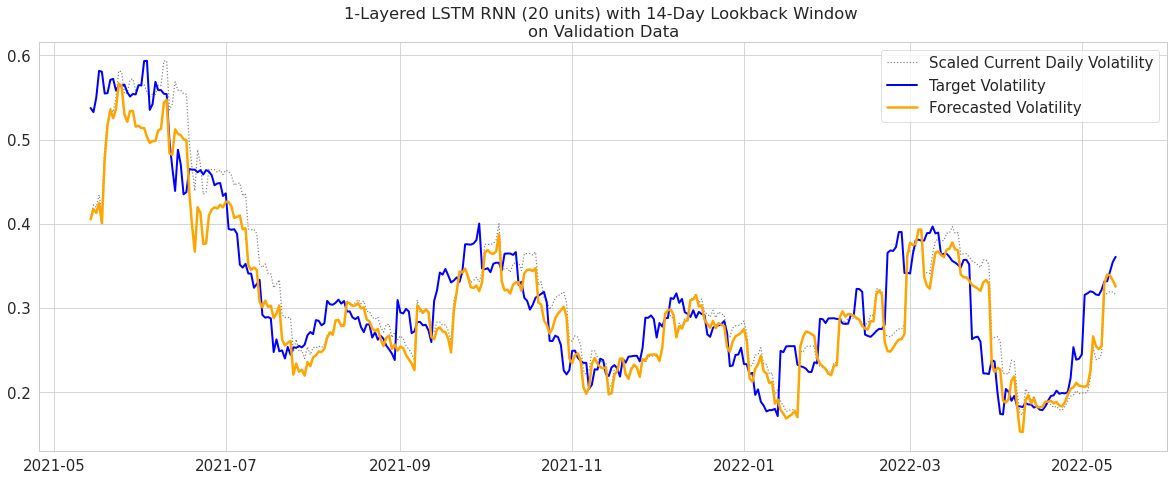

In [120]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
plt.savefig(os.path.join(directory_to_img, 'lstm_1.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

Again, predictions traces `vol_current` quite closely, and the prediction line has smoothed out compared to the fully connected NN's predictions (meaning it's less noisy), but it is still also lagging behind compared to desired target.

In [121]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.281034   
1                           Random Walk Naive Forecasting          0.155975   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517039   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.243379   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.185141   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.190546   
6     Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist          0.177546   
7                 Simple LR Fully Connected NN, n_past=14          0.146846   
8                        LSTM 1 layer 20 units, n_past=14          0.137362   

   Validation RMSE  
0         0.098931  
1         0.046597  
2         0.167036  
3         0.079753  
4         0.063112  
5         0.065726  
6         0.057666  
7         0.042970  
8         0.043995

Simple 1-layered LSTM is only a tiny bit better than fully connected network on RMSPE, and actually has higher RMSE than the simple LR NN above.

### Univariate Bidirectional LSTM



In [122]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

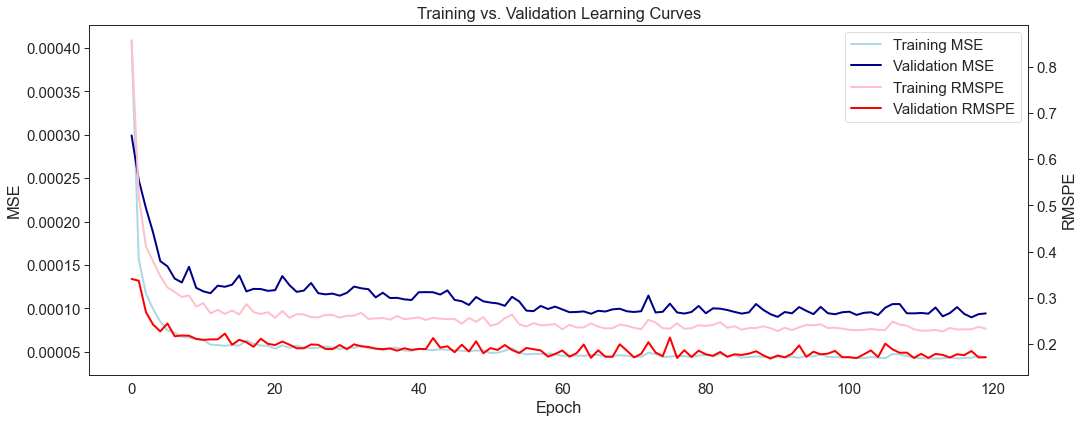

In [124]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [125]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 6s 34ms/step


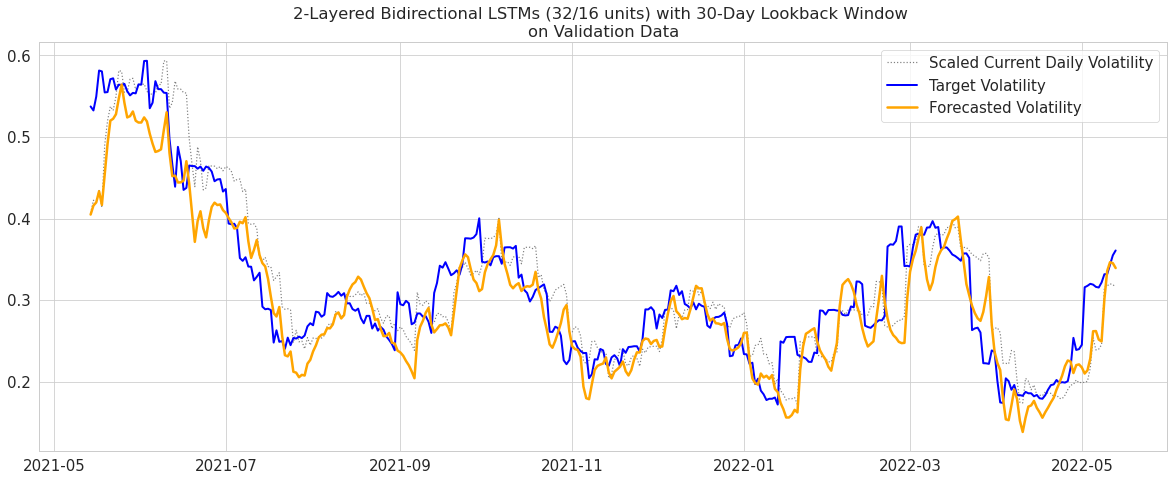

In [126]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")
plt.savefig(os.path.join(directory_to_img, 'lstm_2.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [127]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.281034   
1                           Random Walk Naive Forecasting          0.155975   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517039   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.243379   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.185141   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.190546   
6     Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist          0.177546   
7                 Simple LR Fully Connected NN, n_past=14          0.146846   
8                        LSTM 1 layer 20 units, n_past=14          0.137362   
9         2 layers Bidirect LSTM (32/16 units), n_past=30          0.138564   

   Validation RMSE  
0         0.098931  
1         0.046597  
2         0.167036  
3         0.079753  
4         0.063112  
5         0.065726  
6         0.057666  
7         0.042970  
8         0.043995  
9         0.044816

### Univariate Bidirectional LSTM + 1D Convolutional Layer(s)



In [128]:


# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27,201
Trainable params: 27,201
Non-traina

In [129]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

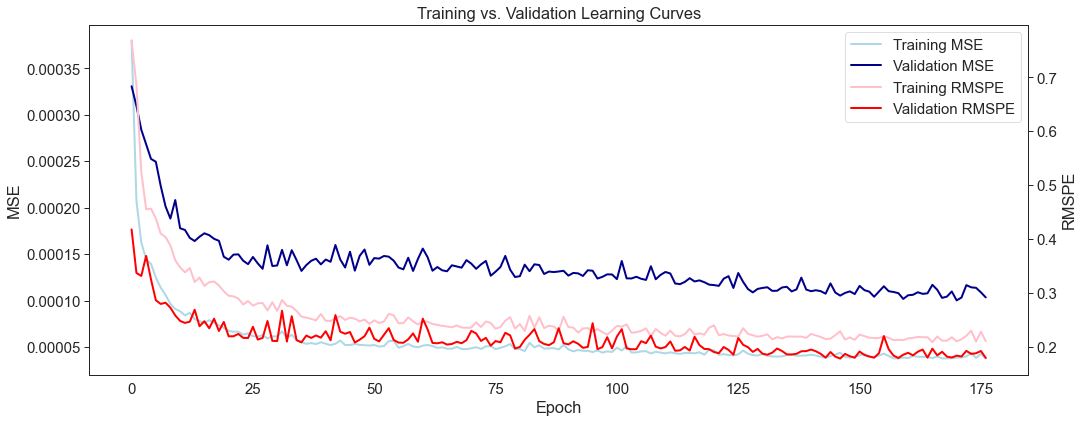

In [130]:
# VISUALIZING TRAINING/VALIDATION METRICS
viz_train_val_metrics(lstm_3_res)

In [131]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 2s 19ms/step


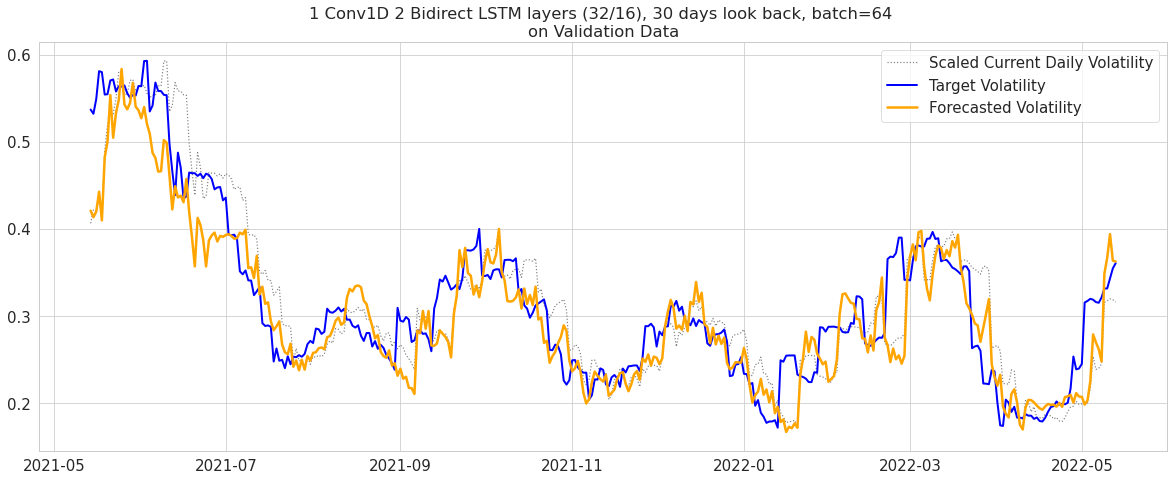

In [132]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
plt.savefig(os.path.join(directory_to_img, 'lstm_3.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [133]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

Model  \
0                                                  Mean Baseline   
1                                  Random Walk Naive Forecasting   
2                         GARCH(1,1), Constant Mean, Normal Dist   
3         Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5               Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6            Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist   
7                        Simple LR Fully Connected NN, n_past=14   
8                               LSTM 1 layer 20 units, n_past=14   
9                2 layers Bidirect LSTM (32/16 units), n_past=30   
10  1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   

    Validation RMSPE  Validation RMSE  
0           0.281034         0.098931  
1           0.155975         0.046597  
2           0.517039         0.167036  
3           0.243379         0.079753  
4           0.185141         0.063112  
5           0.190546         0.065726  
6           0.177546         0.057666  
7           0.146846         0.042970  
8           0.137362         0.043995  
9           0.138564         0.044816  
10          0.131466         0.043514

###  Learning Rate Tuning with SGD Optimizer



In [134]:


# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

# EXPONENTIALLY INCREASE LEARNING RATE 
# BY THE POWER OF 10 EVERY 20 EPOCHS
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=160,
                        callbacks=[lr_schedule],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

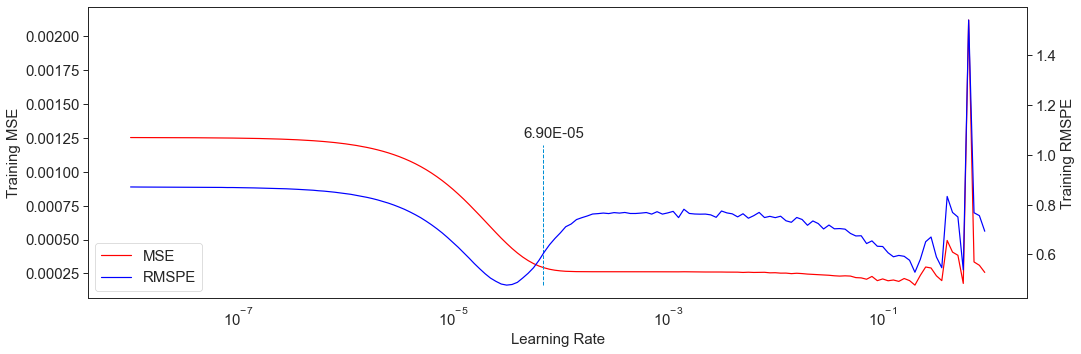

In [135]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,5))

    # PLOT MSE - LEFT Y-AXIS
    ln1 = ax.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['loss'], 
                color='red', label='MSE')
    ax.set_xlabel('Learning Rate', fontsize=15)
    ax.set_ylabel('Training MSE', fontsize=15)

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln2 = ax2.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['rmspe'],
                color='blue', label='RMSPE')
    ax2.set_ylabel('Training RMSPE', fontsize=15)

    # COMBINING LALBELS FOR 2 LINES INTO 1 LEGEND
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower left')

    best_lr = 6.9e-5

    ax.vlines(x=best_lr, ls='--', lw=1,
            ymin=np.min(lstm_4_res.history["loss"]),
            ymax=0.0012)

    ax.text(4.5e-5, 0.00125, '%.2E' % Decimal(best_lr), fontsize=15)

    plt.show();

In [136]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_4.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

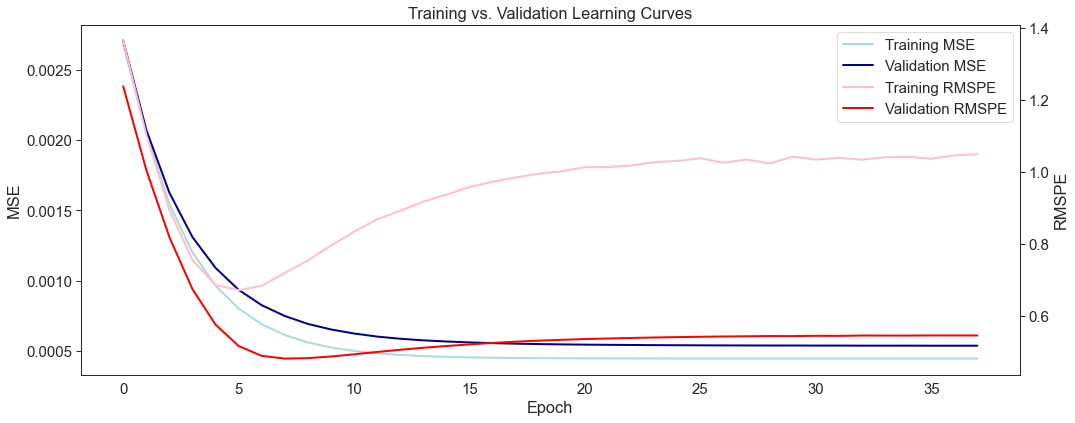

In [137]:
# VISUALIZING TRAINING/VALIDATION LEARNING CURVES
viz_train_val_metrics(lstm_4_res)

In [138]:
# FORECASTING ON VALIDATION SET
lstm_4_preds = forecast(lstm_4, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_4_preds_scaled = scale(scaler_vol, lstm_4_preds)

12/12 [==============================] - 7s 34ms/step


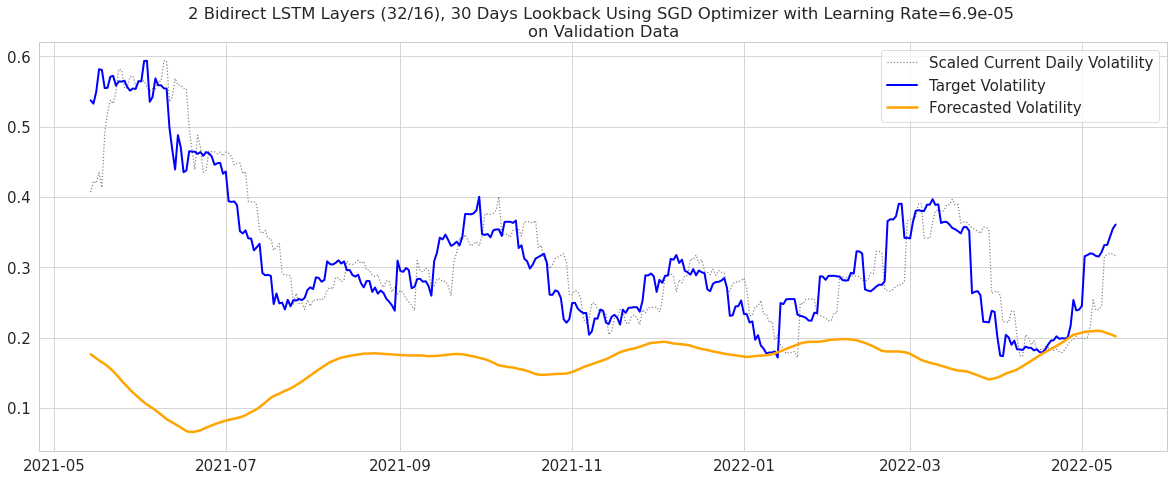

In [139]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_4_preds_scaled, 
          f"2 Bidirect LSTM Layers (32/16), {n_past} Days Lookback Using SGD Optimizer with Learning Rate={best_lr}")
plt.savefig(os.path.join(directory_to_img, 'lstm_4.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

This customized optimizer seems to prioritize volatility's long-term tendency to revert to the mean. Hence the predictions hovers where the mean is.

In [140]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_4_preds_scaled, 
         f"2 Bidirect LSTMs (32/16), n_past={n_past}, batch={batch_size}, SGD lr={best_lr}")

Model  \
0                                                   Mean Baseline   
1                                   Random Walk Naive Forecasting   
2                          GARCH(1,1), Constant Mean, Normal Dist   
3          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6             Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist   
7                         Simple LR Fully Connected NN, n_past=14   
8                                LSTM 1 layer 20 units, n_past=14   
9                 2 layers Bidirect LSTM (32/16 units), n_past=30   
10   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11  2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05   

    Validation RMSPE  Validation RMSE  
0           0.281034         0.098931  
1           0.155975         0.046597  
2           0.517039         0.167036  
3           0.243379         0.079753  
4           0.185141         0.063112  
5           0.190546         0.065726  
6           0.177546         0.057666  
7           0.146846         0.042970  
8           0.137362         0.043995  
9           0.138564         0.044816  
10          0.131466         0.043514  
11          0.479588         0.193640

###  Multivariate LSTM



In [141]:
df.head()

Open        High         Low       Close    Volume  \
Date                                                                   
2014-10-17  382.756012  385.477997  375.389008  383.757996  13600700   
2014-10-18  383.976013  395.157990  378.971008  391.441986  11416800   
2014-10-19  391.253998  393.938995  386.457001  389.545990   5914570   
2014-10-20  389.230988  390.084015  378.252014  382.845001  16419000   
2014-10-21  382.420990  392.645996  380.834015  386.475006  14188900   

             returns  log_returns  vol_current  vol_future  
Date                                                        
2014-10-17  0.314201     0.003137     0.039872    0.032900  
2014-10-18  2.002301     0.019825     0.037566    0.033009  
2014-10-19 -0.484362    -0.004855     0.035089    0.033083  
2014-10-20 -1.720205    -0.017352     0.034629    0.033017  
2014-10-21  0.948166     0.009437     0.034362    0.031334

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2796 entries, 2014-10-17 to 2022-06-12
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         2796 non-null   float64
 1   High         2796 non-null   float64
 2   Low          2796 non-null   float64
 3   Close        2796 non-null   float64
 4   Volume       2796 non-null   int64  
 5   returns      2796 non-null   float64
 6   log_returns  2796 non-null   float64
 7   vol_current  2796 non-null   float64
 8   vol_future   2796 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 283.0 KB


In [143]:
df.describe()

Open          High           Low         Close        Volume  \
count   2796.000000   2796.000000   2796.000000   2796.000000  2.796000e+03   
mean   12489.598243  12814.967895  12127.225698  12497.342462  1.546546e+10   
std    16679.645349  17110.709689  16181.131644  16676.467415  1.996840e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      652.598984    658.991745    638.841507    654.012985  9.146307e+07   
50%     6578.790039   6678.070068   6455.099854   6581.494873  5.872356e+09   
75%    11429.235840  11723.547607  11179.158447  11443.236816  2.630804e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  2796.000000  2796.000000  2796.000000  2796.000000  
mean      0.227673     0.001519     0.036171     0.036204  
std       3.871775     0.039032     0.016434     0.016445  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.351537    -0.013608     0.025228     0.025228  
50%       0.199600     0.001994     0.034170     0.034185  
75%       1.820711     0.018043     0.044721     0.044788  
max      25.247169     0.225119     0.103878     0.103878

#### Feature Engineering



In [144]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [145]:
df.head()

Open        High         Low       Close     Volume  \
Date                                                                    
2014-10-17  382.756012  385.477997  375.389008  383.757996  16.425632   
2014-10-18  383.976013  395.157990  378.971008  391.441986  16.250597   
2014-10-19  391.253998  393.938995  386.457001  389.545990  15.592929   
2014-10-20  389.230988  390.084015  378.252014  382.845001  16.613950   
2014-10-21  382.420990  392.645996  380.834015  386.475006  16.467971   

             returns  log_returns  vol_current  vol_future   HL_sprd   CO_sprd  
Date                                                                            
2014-10-17  0.314201     0.003137     0.039872    0.032900 -3.638567  0.002618  
2014-10-18  2.002301     0.019825     0.037566    0.033009 -3.185630  0.019444  
2014-10-19 -0.484362    -0.004855     0.035089    0.033083 -3.952483 -0.004365  
2014-10-20 -1.720205    -0.017352     0.034629    0.033017 -3.476822 -0.016407  
2014-10-21  0.948166     0.009437     0.034362    0.031334 -3.487953  0.010601

In [146]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

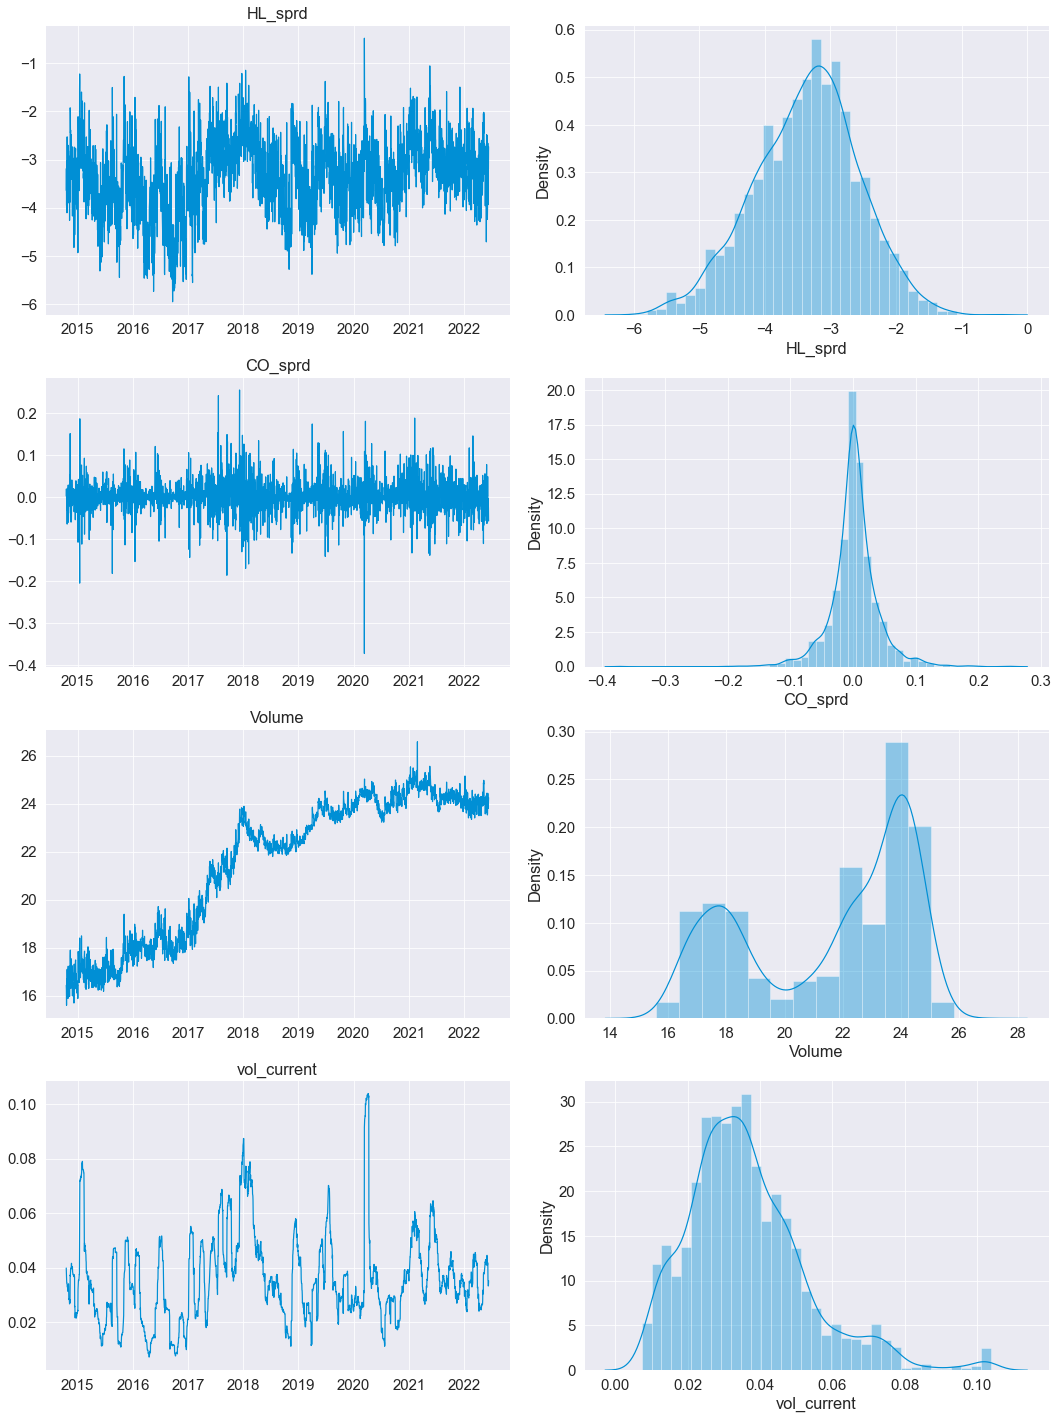

In [147]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'features.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [148]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [149]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                  
2014-10-17 -3.638567  0.002618  16.425632     0.039872
2014-10-18 -3.185630  0.019444  16.250597     0.037566
2014-10-19 -3.952483 -0.004365  15.592929     0.035089
2014-10-20 -3.476822 -0.016407  16.613950     0.034629
2014-10-21 -3.487953  0.010601  16.467971     0.034362

In [150]:
input_df.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                  
2014-10-17 -3.638567  0.002618  16.425632     0.039872
2014-10-18 -3.185630  0.019444  16.250597     0.037566
2014-10-19 -3.952483 -0.004365  15.592929     0.035089
2014-10-20 -3.476822 -0.016407  16.613950     0.034629
2014-10-21 -3.487953  0.010601  16.467971     0.034362

In [151]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2401 entries, 2014-10-17 to 2021-05-13
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2401 non-null   float64
 1   CO_sprd      2401 non-null   float64
 2   Volume       2401 non-null   float64
 3   vol_current  2401 non-null   float64
dtypes: float64(4)
memory usage: 93.8 KB


In [152]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2796 entries, 2014-10-17 to 2022-06-12
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2796 non-null   float64
 1   CO_sprd      2796 non-null   float64
 2   Volume       2796 non-null   float64
 3   vol_current  2796 non-null   float64
dtypes: float64(4)
memory usage: 173.8 KB


In [153]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

###  Multivariate 2-Layered Bidirectional LSTM with Dropout


In [154]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           9472      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [155]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

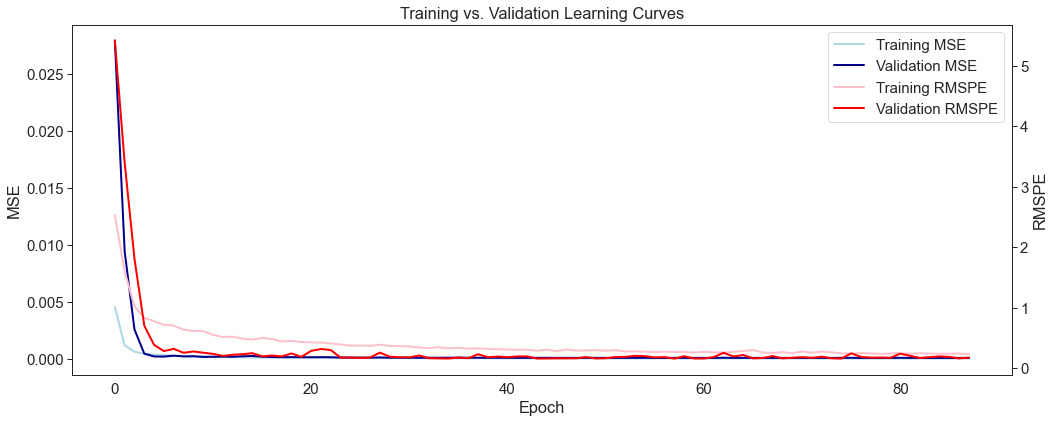

In [156]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [157]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 5s 52ms/step


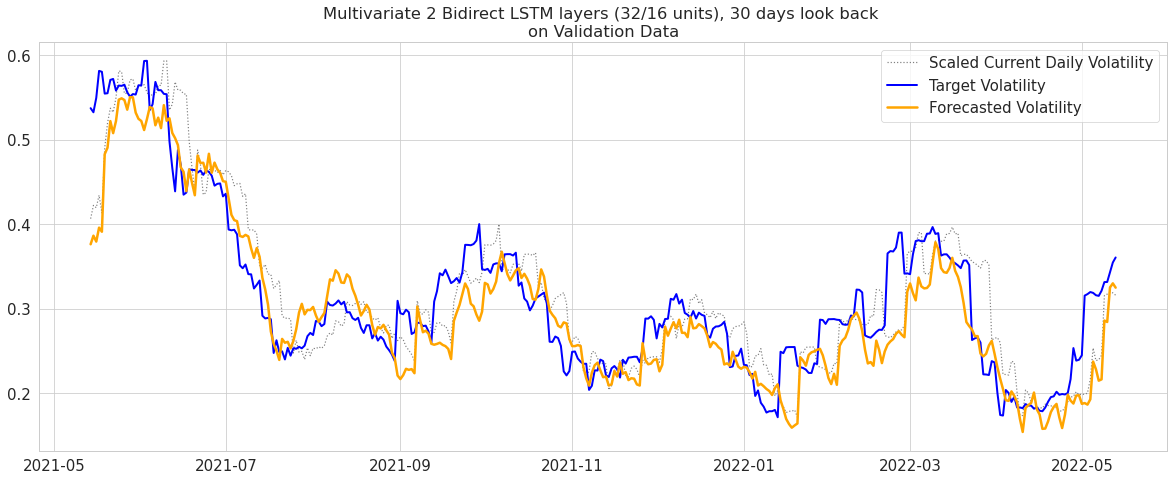

In [158]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")
plt.savefig(os.path.join(directory_to_img, 'lstm_5.png'), 
            dpi=300, bbox_inch='tight')
plt.show();

In [159]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Model  \
0                                                   Mean Baseline   
1                                   Random Walk Naive Forecasting   
2                          GARCH(1,1), Constant Mean, Normal Dist   
3          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6             Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist   
7                         Simple LR Fully Connected NN, n_past=14   
8                                LSTM 1 layer 20 units, n_past=14   
9                 2 layers Bidirect LSTM (32/16 units), n_past=30   
10   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11  2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05   
12   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   

    Validation RMSPE  Validation RMSE  
0           0.281034         0.098931  
1           0.155975         0.046597  
2           0.517039         0.167036  
3           0.243379         0.079753  
4           0.185141         0.063112  
5           0.190546         0.065726  
6           0.177546         0.057666  
7           0.146846         0.042970  
8           0.137362         0.043995  
9           0.138564         0.044816  
10          0.131466         0.043514  
11          0.479588         0.193640  
12          0.135944         0.045277

###  Multivariate 3-Layered Bidirectional LSTM



In [160]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 
    
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          35328     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 64)           41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [161]:
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

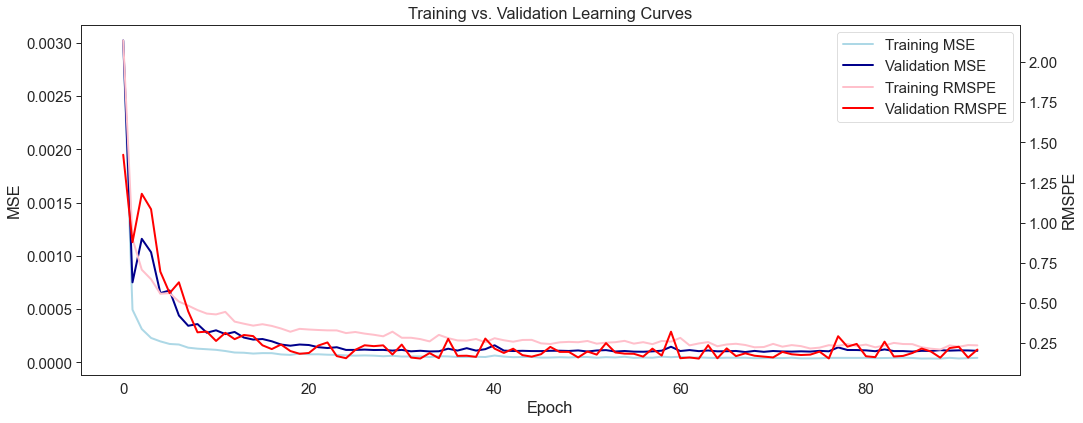

In [162]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)

In [163]:
# FORECASTING ON VALIDATION SET
lstm_6_preds = forecast_multi(lstm_6, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)

12/12 [==============================] - 10s 42ms/step


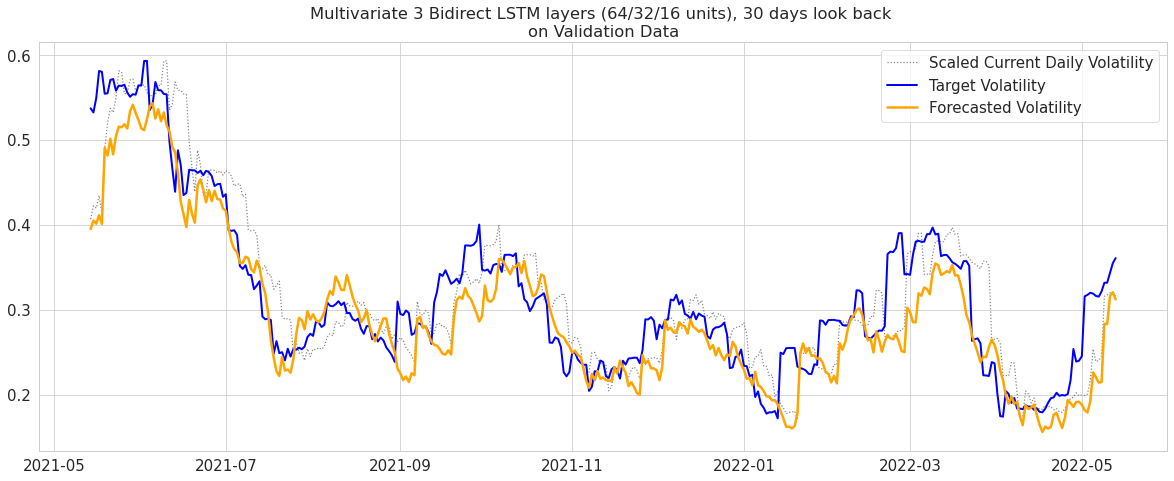

In [164]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_6_preds_scaled, 
          f"Multivariate 3 Bidirect LSTM layers (64/32/16 units), {n_past} days look back")
plt.savefig(os.path.join(directory_to_img, 'lstm_6.png'), 
            dpi=300, bbox_inch='tight')
plt.show();

In [165]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past={n_past}")

Model  \
0                                                     Mean Baseline   
1                                     Random Walk Naive Forecasting   
2                            GARCH(1,1), Constant Mean, Normal Dist   
3            Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                   Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                  Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6               Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist   
7                           Simple LR Fully Connected NN, n_past=14   
8                                  LSTM 1 layer 20 units, n_past=14   
9                   2 layers Bidirect LSTM (32/16 units), n_past=30   
10     1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11    2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05   
12     Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
13  Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   

    Validation RMSPE  Validation RMSE  
0           0.281034         0.098931  
1           0.155975         0.046597  
2           0.517039         0.167036  
3           0.243379         0.079753  
4           0.185141         0.063112  
5           0.190546         0.065726  
6           0.177546         0.057666  
7           0.146846         0.042970  
8           0.137362         0.043995  
9           0.138564         0.044816  
10          0.131466         0.043514  
11          0.479588         0.193640  
12          0.135944         0.045277  
13          0.138059         0.045963

###  Multivariate 4-Layered Bidirectional LSTM

In [166]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 4th LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          136192    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                        

In [167]:
# FITTING TO TRAINING DATA
lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

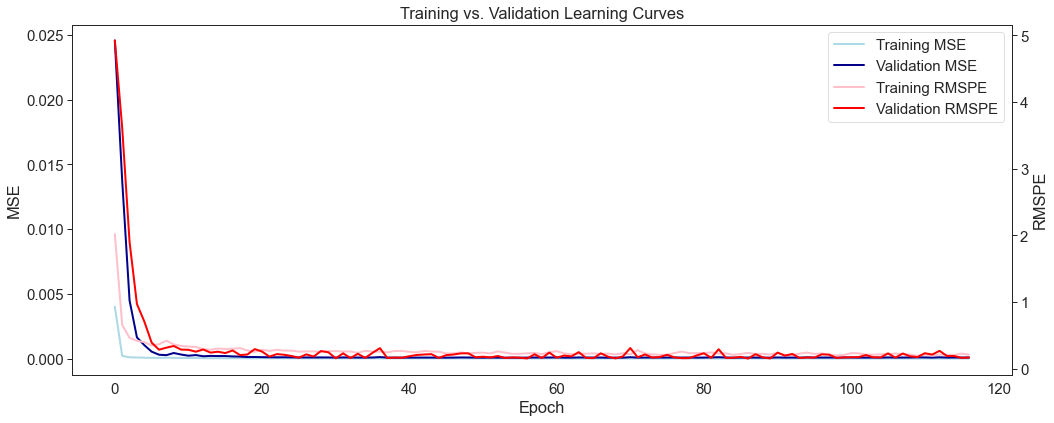

In [168]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_7_res)

In [169]:
# FORECASTING ON VALIDATION SET
lstm_7_preds = forecast_multi(lstm_7, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_7_preds_scaled = scale(scaler_vol, lstm_7_preds)

12/12 [==============================] - 13s 132ms/step


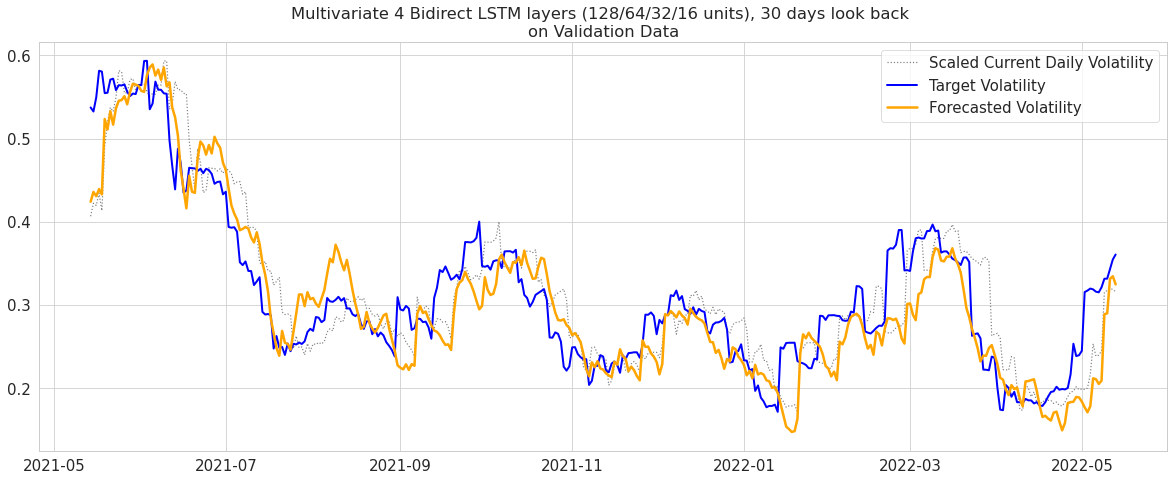

In [170]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_7_preds_scaled, 
          f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), {n_past} days look back")
plt.savefig(os.path.join(directory_to_img, 'lstm_7_preds.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [171]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled, 
         f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                                                   Mean Baseline   
1                                                   Random Walk Naive Forecasting   
2                                          GARCH(1,1), Constant Mean, Normal Dist   
3                          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6                             Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist   
7                                         Simple LR Fully Connected NN, n_past=14   
8                                                LSTM 1 layer 20 units, n_past=14   
9                                 2 layers Bidirect LSTM (32/16 units), n_past=30   
10                   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11                  2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05   
12                   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
13                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   
14  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=30, batch=64   

    Validation RMSPE  Validation RMSE  
0           0.281034         0.098931  
1           0.155975         0.046597  
2           0.517039         0.167036  
3           0.243379         0.079753  
4           0.185141         0.063112  
5           0.190546         0.065726  
6           0.177546         0.057666  
7           0.146846         0.042970  
8           0.137362         0.043995  
9           0.138564         0.044816  
10          0.131466         0.043514  
11          0.479588         0.193640  
12          0.135944         0.045277  
13          0.138059         0.045963  
14          0.143576         0.045141

It seems like after 3 layers, validation RMSPE starts going back up.

## **LSTM Network Tuning**


In [172]:
#!pip install talos

In [173]:
import talos

In [174]:
def lstm_network(X_tr, y_tr, X_v, y_v, params):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]))

    # HIDDEN LAYERS
    for layer in range(params['lstm_layers'],1,-1):
        # FOR THE LAST LAYER - return_sequences NEEDS TO BE False
        # ALL OTHER LAYERS - returns_sequences = True
        seq = False if layer == 1 else True
        
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2**(layer+3),
                                                                     return_sequences=seq,
                                                                     activation=params['activation'])))
        model.add(tf.keras.layers.Dropout(params['dropout']))

    model.add(tf.keras.layers.Dense(1))

    # COMPILE
    model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[rmspe])
    
    # STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
    early_stopping_cb = EarlyStopping(patience=3,
                                      restore_best_weights=True,
                                      monitor='val_rmspe')
    # FIT
    res = model.fit(X_tr, y_tr, 
                    validation_data=(X_v, y_v),
                    batch_size=params['batch_size'],
                    epochs=10,
                    verbose=0,
                    callbacks=[early_stopping_cb])
    
    return res, model

In [175]:
params = {'dropout': [0.1, 0.2], 
          'activation': ['relu', 'tanh', 'sigmoid'], 
          'lstm_layers': [2,3,4],
          'batch_size': [32,64]}

In [176]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

from_i = val_idx[0] - timedelta(n_past - 1)
to_i = val_idx[-1]
mat_X_val, mat_y_val = windowed_dataset(input_df[from_i:to_i], 
                                        df.vol_future[val_idx], n_past)

results = talos.Scan(x=mat_X_train, y=mat_y_train, 
                     x_val=mat_X_val, y_val=mat_y_val,
                     params=params, 
                     model=lstm_network,
                     experiment_name='grid',
                     reduction_metric='rmspe',
                     minimize_loss=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [45:47<00:00, 76.31s/it]


In [177]:
results.data.sort_values(by='val_rmspe', ascending=True)[:3]

start              end    duration  round_epochs      loss  \
34  06/20/22-230213  06/20/22-230446  152.644902            10  0.000522   
8   06/20/22-222806  06/20/22-222924   78.188656            10  0.000374   
26  06/20/22-225135  06/20/22-225256   80.902553             8  0.000454   

       rmspe  val_loss  val_rmspe  dropout activation  lstm_layers  batch_size  
34  0.963977  0.000094   0.189011      0.2    sigmoid            4          32  
8   0.828488  0.000091   0.190520      0.1       tanh            3          32  
26  0.903600  0.000093   0.193869      0.2       tanh            3          32

In [178]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 32
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_8 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                                                       activation='tanh')),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='tanh')),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_8.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_8.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           9472      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [179]:
# FITTING TO TRAINING DATA
lstm_8_res = lstm_8.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

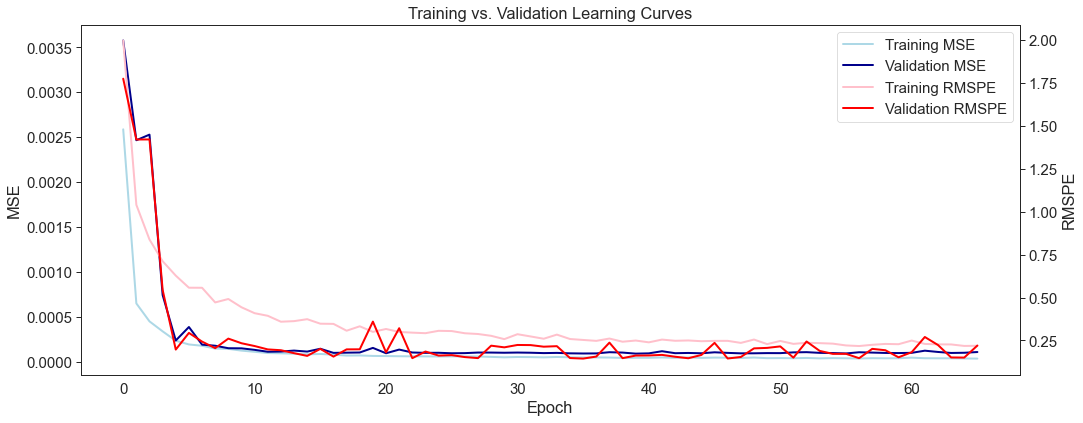

In [180]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_8_res)

In [181]:
# FORECASTING ON VALIDATION SET
lstm_8_preds = forecast_multi(lstm_8, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_8_preds_scaled = scale(scaler_vol, lstm_8_preds)

12/12 [==============================] - 6s 44ms/step


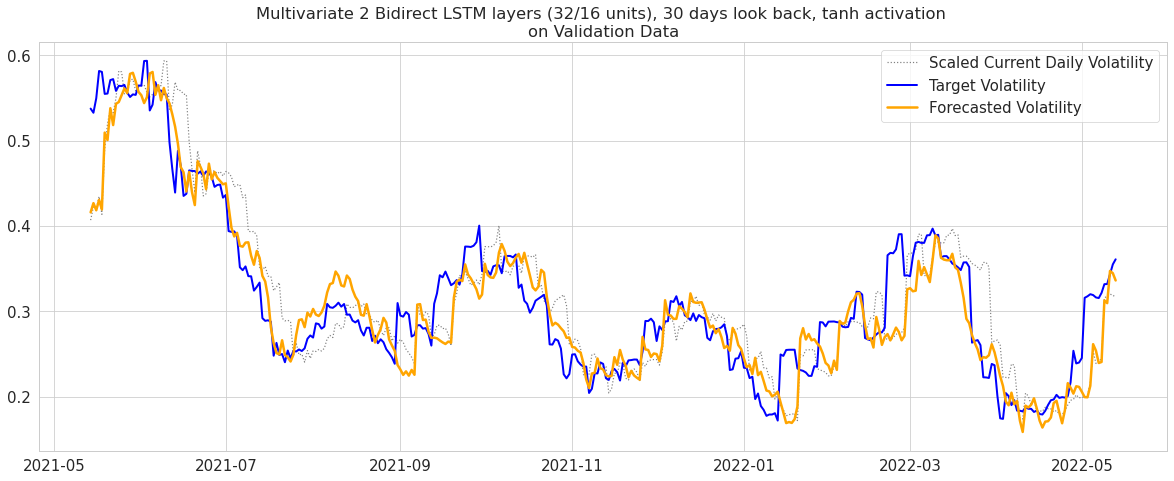

In [182]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_8_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back, tanh activation")
plt.savefig(os.path.join(directory_to_img, 'lstm_8_preds.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [183]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_8_preds_scaled, 
         f"Multivariate 2 Bidirect LSTM layers (32/16 units), n_past={n_past}, batch={batch_size}, tanh")

Model  \
0                                                                   Mean Baseline   
1                                                   Random Walk Naive Forecasting   
2                                          GARCH(1,1), Constant Mean, Normal Dist   
3                          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6                             Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist   
7                                         Simple LR Fully Connected NN, n_past=14   
8                                                LSTM 1 layer 20 units, n_past=14   
9                                 2 layers Bidirect LSTM (32/16 units), n_past=30   
10                   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11                  2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05   
12                   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
13                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   
14  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=30, batch=64   
15   Multivariate 2 Bidirect LSTM layers (32/16 units), n_past=30, batch=32, tanh   

    Validation RMSPE  Validation RMSE  
0           0.281034         0.098931  
1           0.155975         0.046597  
2           0.517039         0.167036  
3           0.243379         0.079753  
4           0.185141         0.063112  
5           0.190546         0.065726  
6           0.177546         0.057666  
7           0.146846         0.042970  
8           0.137362         0.043995  
9           0.138564         0.044816  
10          0.131466         0.043514  
11          0.479588         0.193640  
12          0.135944         0.045277  
13          0.138059         0.045963  
14          0.143576         0.045141  
15          0.120605         0.038602

## **Final Model**

In [184]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

Model  \
15   Multivariate 2 Bidirect LSTM layers (32/16 units), n_past=30, batch=32, tanh   
10                   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
12                   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
8                                                LSTM 1 layer 20 units, n_past=14   
13                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   
9                                 2 layers Bidirect LSTM (32/16 units), n_past=30   
14  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=30, batch=64   
7                                         Simple LR Fully Connected NN, n_past=14   
1                                                   Random Walk Naive Forecasting   
6                             Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt Dist   
4                                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
3                          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
0                                                                   Mean Baseline   
11                  2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05   
2                                          GARCH(1,1), Constant Mean, Normal Dist   

    Validation RMSPE  Validation RMSE  
15          0.120605         0.038602  
10          0.131466         0.043514  
12          0.135944         0.045277  
8           0.137362         0.043995  
13          0.138059         0.045963  
9           0.138564         0.044816  
14          0.143576         0.045141  
7           0.146846         0.042970  
1           0.155975         0.046597  
6           0.177546         0.057666  
4           0.185141         0.063112  
5           0.190546         0.065726  
3           0.243379         0.079753  
0           0.281034         0.098931  
11          0.479588         0.193640  
2           0.517039         0.167036

In [185]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [186]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           9472      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [187]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

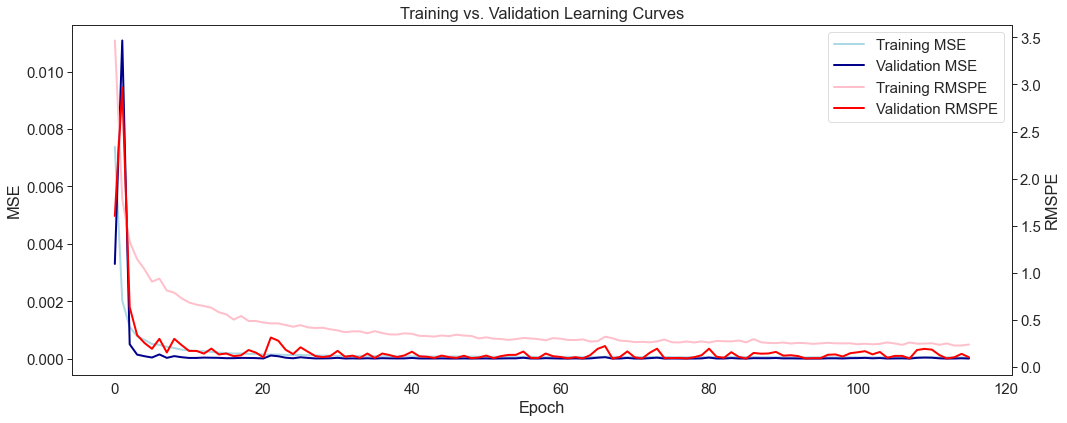

In [188]:
viz_train_val_metrics(lstm_final_res)

### Final Model's Predictions on Test Set

In [189]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)

1/1 [==============================] - 6s 6s/step


In [190]:
y_test_preds.describe()

count    30.000000
mean      0.039313
std       0.004784
min       0.030392
25%       0.034413
50%       0.041485
75%       0.042826
max       0.043907
dtype: float64

In [191]:
y_test.describe()

count    30.000000
mean      0.042470
std       0.004661
min       0.033286
25%       0.041078
50%       0.042447
75%       0.044518
max       0.051245
Name: vol_future, dtype: float64

In [192]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [193]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

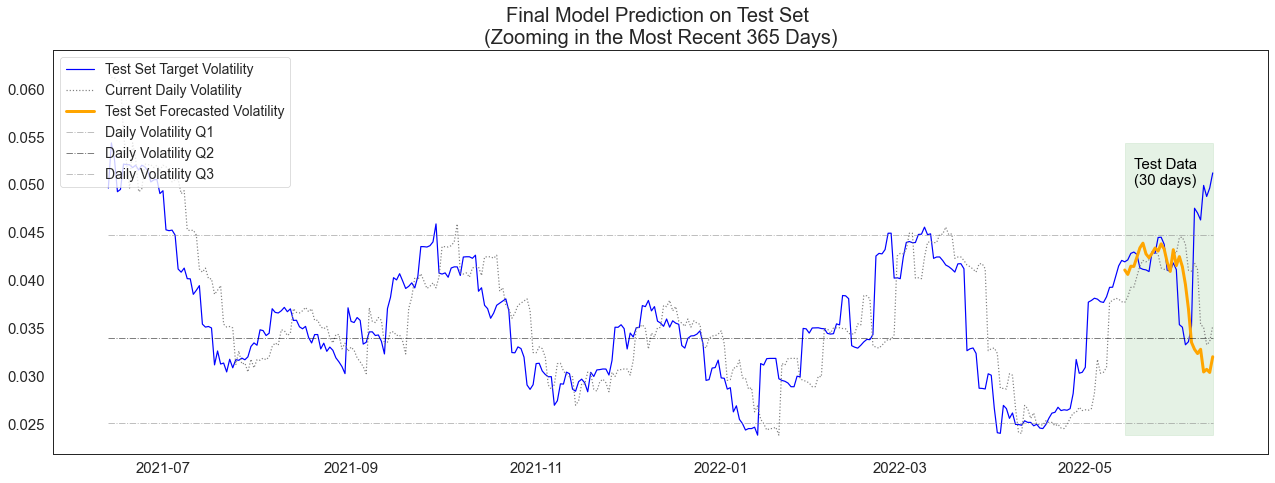

In [194]:


# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Test Set Target Volatility")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')
    
    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])
        
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_test_preds.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [195]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0], 
                      index=df.index[-(mat_X_all).shape[0]:])

87/87 [==============================] - 3s 35ms/step


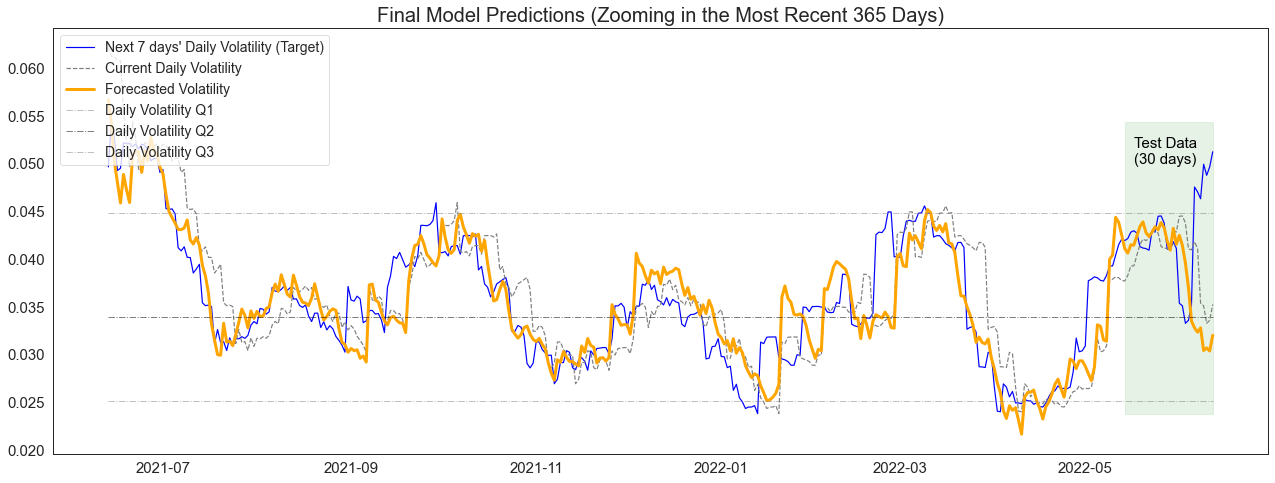

In [196]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)
    
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_preds.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [197]:
perf_df.to_pickle("performance_df.pkl")

In [234]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

RMSPE on Test Set: 0.053450330401007703


In [235]:
1-RMSPE(y_test, y_test_preds)

0.9465496695989923